# Self-Driving Car Engineer Nanodegree
## Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Camera Calibration

The code for this step is contained in the following cell (cameraCalibration function).
The output of the cameraCalibration function is 
 - Object points : 3d  points in real world space 
 - Image points : 2d points in the image plane

Steps
- Twenty one different images of chessboard pattern are used for camera calibration. 
- convert the images from BGR 2 GRAY scale
- Find the chess board corner using cv2.findChessboardCorners function
- Use cv2.calibrateCamera function to do camera calibration. The output of which is used to undistort the image


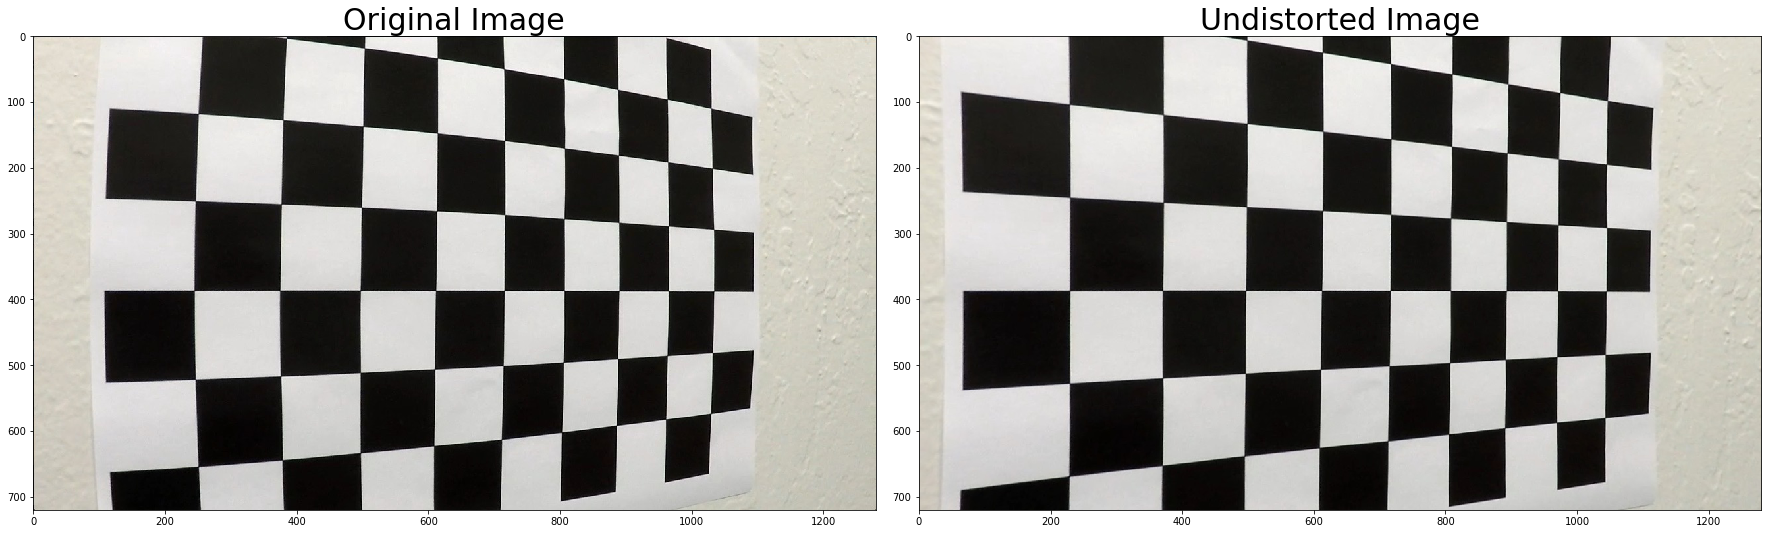

In [245]:
# Import all the packages needed for Advanced lane finding 
import numpy as np    
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import random
%matplotlib inline

images = glob.glob('camera_cal/calibration*.jpg')
one_image = mpimg.imread('camera_cal/calibration5.jpg')

def cameraCalibration(img):
    img_size = one_image.shape[:2]
    objp = np.zeros((6*9,3), np.float32)
    # modify the array 
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
    # idx is the index and fname is the image name
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
       # print (ret, corners.shape)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)


    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size[:2],None,None)
    return ret, mtx, dist, rvecs, tvecs
ret, mtx, dist, rvecs, tvecs = cameraCalibration(one_image)

img = cv2.undistort(one_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(one_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Following is an example of distortion correction image

# Distortion Correction
Distortion correction on one single image


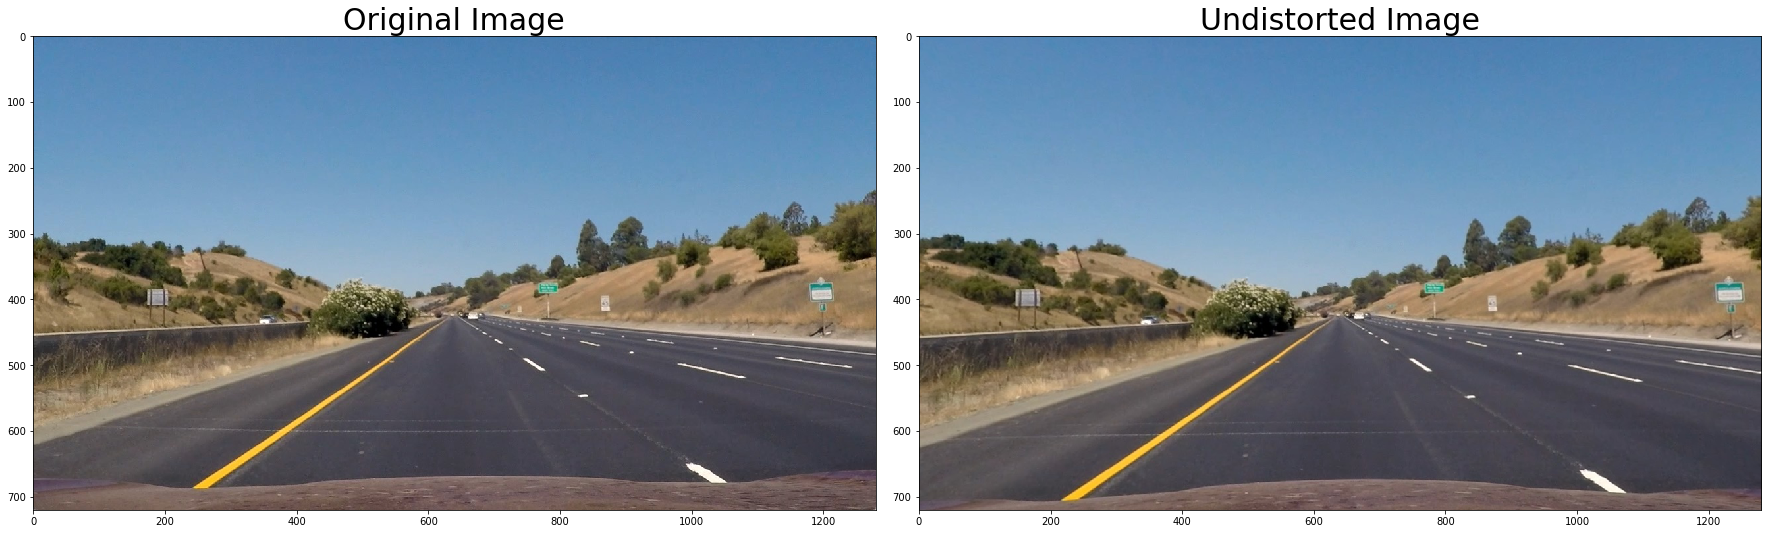

In [246]:
img1 = mpimg.imread('test_images/straight_lines1.jpg')

img_und = cv2.undistort(img1, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_und)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



# Image Threshold

Multiple Thresholds are applied on the image 

- Extract the S-channel of the original image in HLS format and combined the result with the extracted V-channel of the original image in HSV format.
- Both, Sobel X and Y operators are used to filter the original image for the strongest gradients.



In [247]:

def undistort(img,mtx,dist):
    img_undes = cv2.undistort(img, mtx, dist, None, mtx)   
    return img_undes
    


In [250]:

def thresholding3(img,mtx,dist):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary_outputx = np.zeros_like(scaled_sobelx)
    binary_outputx[(scaled_sobelx >= 15) & (scaled_sobelx <= 255)] = 1
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    binary_outputy = np.zeros_like(scaled_sobely)
    binary_outputy[(scaled_sobely >= 35) & (scaled_sobely <= 255)] = 1
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    binary_outputgm = np.zeros_like(grad_mag)
    binary_outputgm[(grad_mag >= 60) & (grad_mag <= 255)] = 1
    
    grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_outputgd =  np.zeros_like(grad_dir)
    binary_outputgd[(grad_dir >= 0.7) & (grad_dir <= 1.1)] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > 60) & (s_channel <= 255)] = 1
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > 120) & (v_channel <= 255)] = 1  
    binary_outputc = np.zeros_like(s_channel)
    binary_outputc[(s_binary == 1) & (v_binary == 1)] = 1
    
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(img)
    binary_output[(binary_outputx == 1) & (binary_outputy == 1) & (binary_outputgm == 1) | (binary_outputc == 1) | (binary_outputgm == 1) & (binary_outputgd == 1)] = 1
    return binary_output


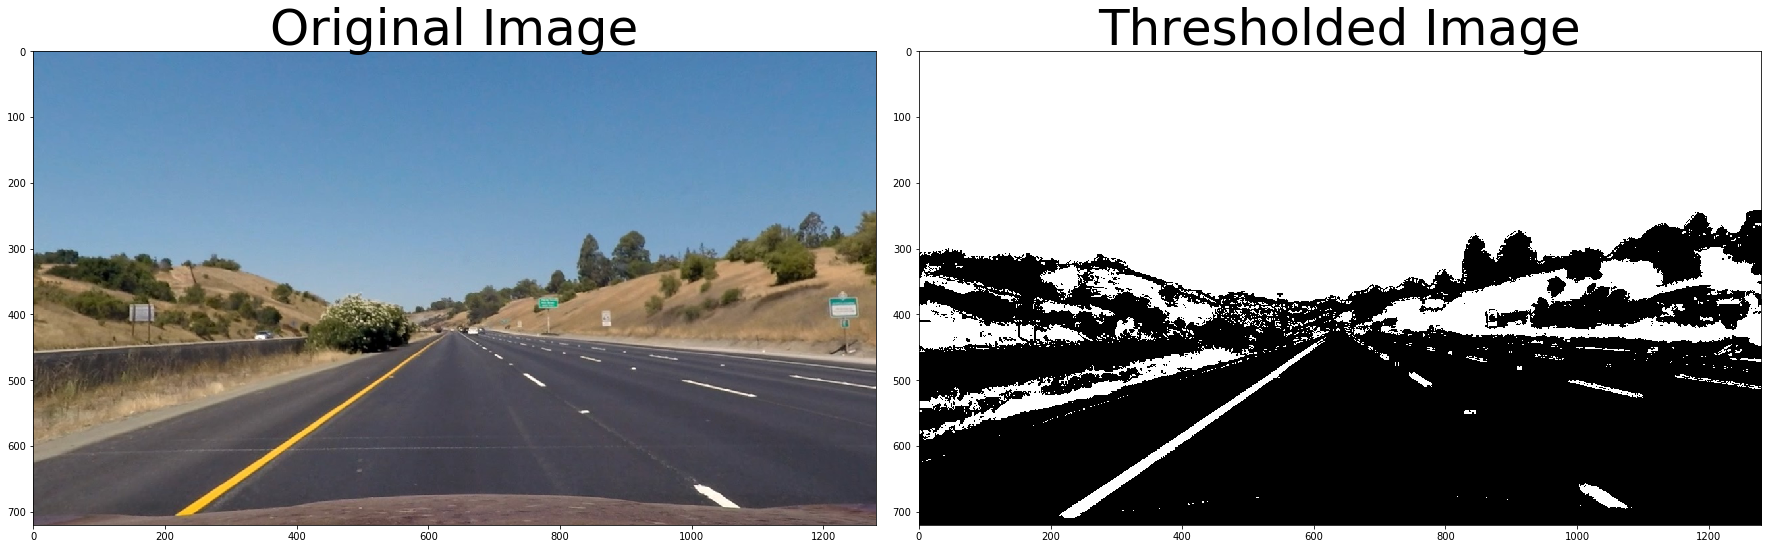

In [251]:
combined_binary = thresholding3(img_und,mtx,dist)
# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_und)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)






# Region masking

The unwanted region is masking away for left and right lanes. 
The results are shown below.



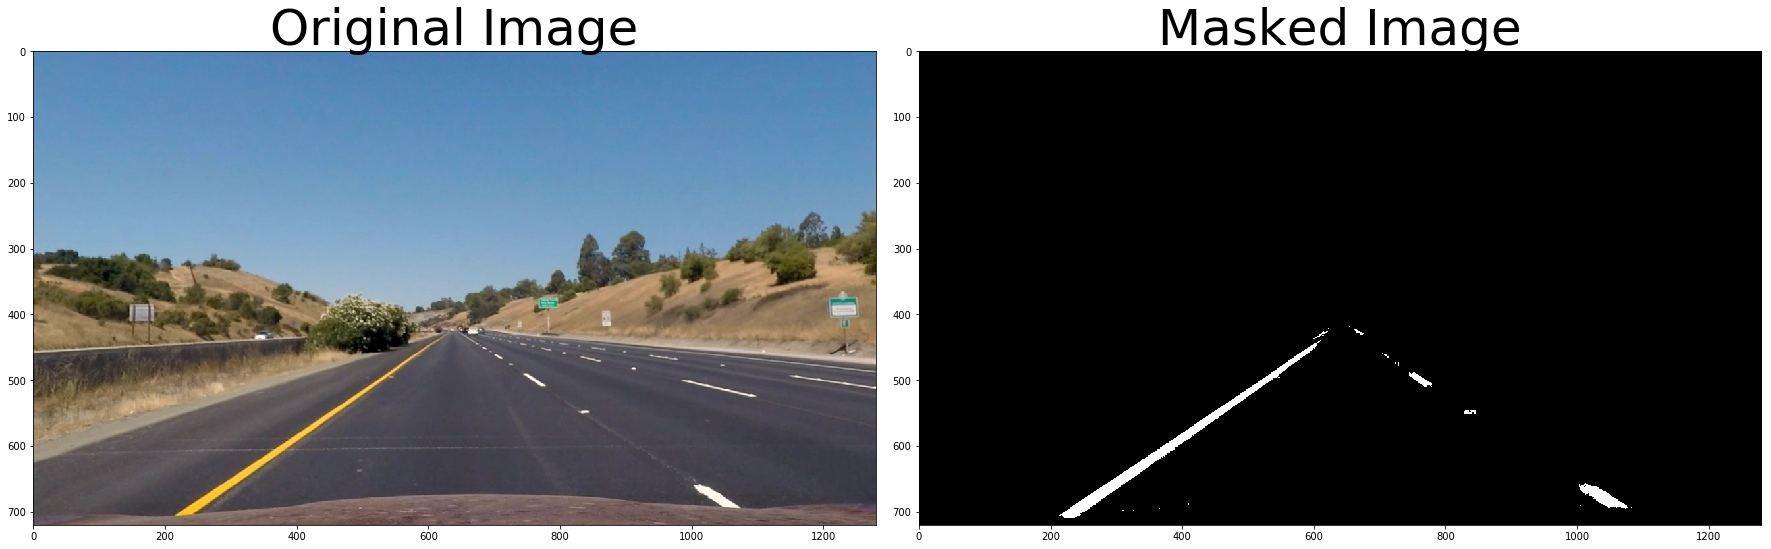

In [252]:
def masked_region(img):
    width = img.shape[1]
    height = img.shape[0]
    left_pts = np.array([[(width*0.49, height*0.58),
                        (width*0.49, height*0.58),
                        (width*0.3, height),
                        (width*0.15, height)]], 
                        dtype=np.int32)
    right_pts = np.array([[(width*0.51, height*0.58),
                        (width*0.51, height*0.58),
                        (width*0.95, height),
                        (width*0.8, height)]], 
                        dtype=np.int32)
    
    
    
    mask_l = np.zeros_like(img)  
    mask_r = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask_l, left_pts, ignore_mask_color)
    masked_image_l = cv2.bitwise_and(img, mask_l)
    cv2.fillPoly(mask_r, right_pts, ignore_mask_color)
    masked_image_r = cv2.bitwise_and(img, mask_r)
    masked_image = cv2.addWeighted(masked_image_l, 1.0, masked_image_r, 1.0, 0)
    return masked_image


masked_binary = masked_region(combined_binary)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_und)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(masked_binary, cmap='gray')
ax2.set_title('Masked Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform 

- The source and destinations points are used based on the feedback. 


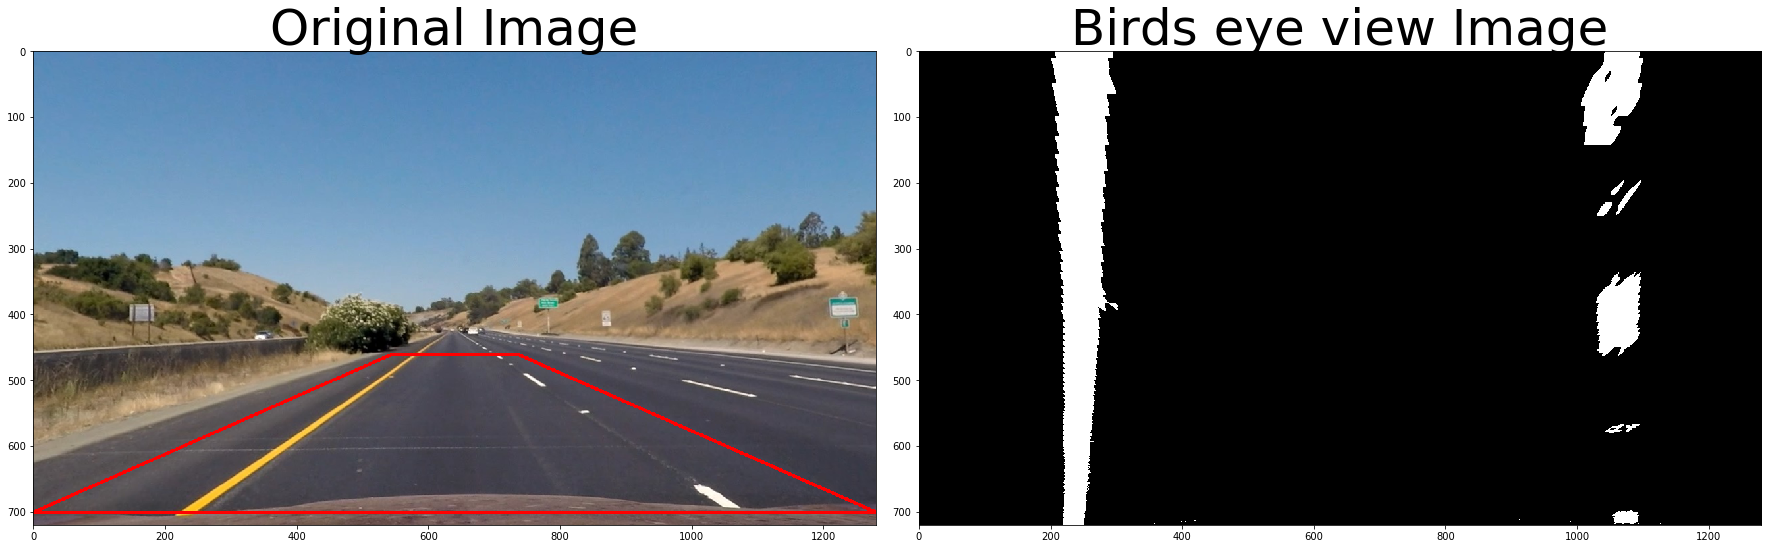

In [253]:
def perspective_transform2(img):
    width = img.shape[1]
    height = img.shape[0]    
    src = np.float32([[545, 460],
                    [735, 460],
                    [1280, 700],
                    [0, 700]])

    dst = np.float32([[0, 0],
                     [1280, 0],
                     [1280, 720],
                     [0, 720]])
    
    pts = np.array([src], np.int32)
    pts = pts.reshape((-1,1,2))
    
    
    copy = img.copy()
    ps = cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)


    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_output = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return ps, warped_output, M, Minv


ps,transformed,M, M_inv = perspective_transform2(combined_binary)
pso,transformedx,Mx, M_invx = perspective_transform2(img_und)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(pso)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(transformed, cmap='gray')
ax2.set_title('Birds eye view Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Lane line pixel detection

A sliding window search is performed to detect the lane pixels. A histogram is used as a starting point to identify the starting points of the lane. Once the starting points are initialized, sliding window search is used to detect the remaining lane pixels. 
- Number of windows used = 10
- Number of minimum pixels detected = 150
- Margin (width of the window +/- margin) = 80



(720, 0)

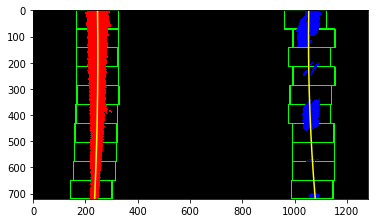

In [254]:

def sliding_window(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 150
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
     # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

  
    return  out_img,left_fit, right_fit, left_fitx, right_fitx,ploty

out_img,left_fit, right_fit, left_fitx, right_fitx,ploty = sliding_window(transformed)



plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720,0)

(720, 0)

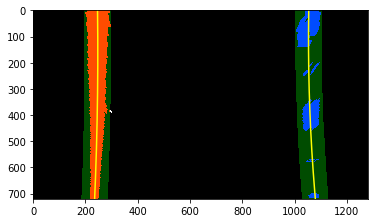

In [255]:
def non_sliding_window(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = []
    right_lane_inds = []
    out_img = np.dstack((img, img, img))*255

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    
        # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)



    return  result, left_fitx, right_fitx, ploty

out_img, left_fitx, right_fitx, ploty = non_sliding_window(transformed, left_fit, right_fit)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, img.shape[1])
plt.ylim(img.shape[0],0)


In [256]:
def radius(ploty,left_fitx,right_fitx,img):
    y_eval = np.max(ploty)
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.5/1280 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    diff_radius = abs(left_curverad-right_curverad)
   # print(left_curverad, 'm', right_curverad, 'm', diff_radius)
    #Find Car position
    car_p = 640
    lane_p = (left_fitx[0]+right_fitx[0])/2
    offset_from_center = (car_p-lane_p)*xm_per_pix
    print ("offset_from_center",offset_from_center)
    return left_curverad,right_curverad,offset_from_center

left_curverad,right_curverad,offset_from_center  = radius(ploty,left_fitx,right_fitx,img)
print ("Left lane radius",left_curverad)
print ("Right lane radius", right_curverad)
print ("Offset from center", offset_from_center)



offset_from_center -0.0278784819367
Left lane radius 8163.96573347
Right lane radius 4473.13684817
Offset from center -0.0278784819367


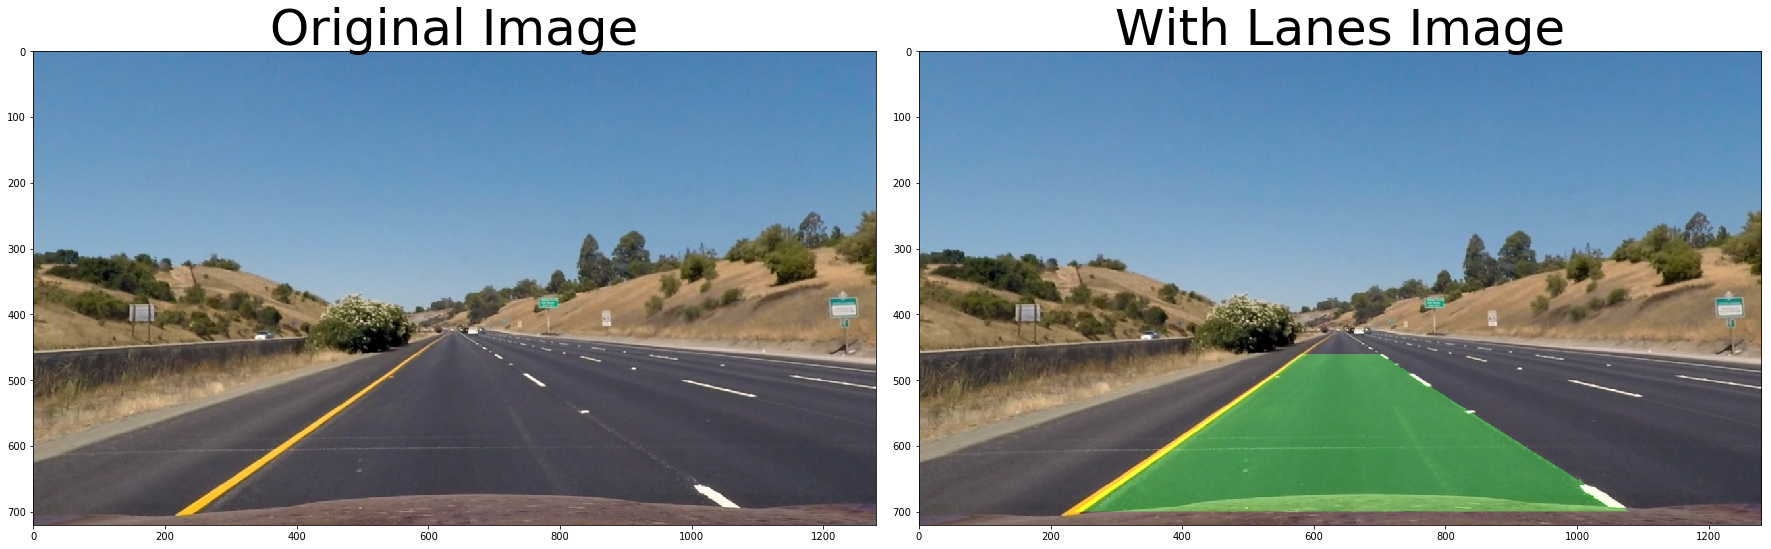

In [257]:
def draw_lanes(warped,img,left_fitx,right_fitx,ploty,M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result


img1 = mpimg.imread('test_images/straight_lines1.jpg')

img1  = undistort(img1,mtx,dist)

result = draw_lanes(transformed,img1,left_fitx,right_fitx,ploty,M_inv)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('With Lanes Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


0.0
offset_from_center -0.0276998999167


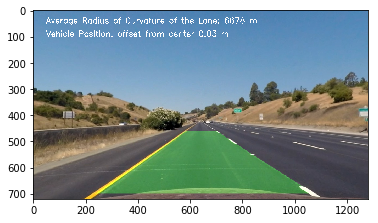

In [259]:
ret, mtx, dist, rvecs, tvecs = cameraCalibration(one_image)

frames = 2
left_fit_str = None
right_fit_str = None
compare = None
offset_str = None
def pipeline(img): 
    img  = undistort(img,mtx,dist)


    combined_binary = thresholding3(img,mtx,dist)
    copy,warped, M, M_inv = perspective_transform2(combined_binary)
    out_img,left_fit, right_fit, left_fitx, right_fitx,ploty = sliding_window(warped)
   # out_img, left_fitx, right_fitx, ploty = non_sliding_window(warped, left_fit, right_fit)


    global right_fit_str
    global left_fit_str
    global compare
    global offset_str
    
    if compare is None:
        compare = combined_binary
        
    ret = cv2.matchShapes(compare, combined_binary, 1, 0.0)
    print (ret)
    if ret < 50:
        old_img_lines = combined_binary

        if left_fit_str is None:
            left_fit_str = np.array([left_fitx])

        if right_fit_str is None:
            right_fit_str = np.array([right_fitx])

        left_fit_str = np.append(left_fit_str, [left_fitx], axis=0)[-frames:]
        right_fit_str = np.append(right_fit_str, [right_fitx], axis=0)[-frames:]

    # Compute the mean
    left_fit_mean = np.mean(left_fit_str, axis=0)
    right_fit_mean = np.mean(right_fit_str, axis=0)

    result = draw_lanes(warped,img,left_fit_mean,right_fit_mean,ploty,M_inv)
    left_curverad,right_curverad,offset_from_center =radius(ploty,left_fit_mean,right_fit_mean,warped)
    avg_radius_meters = np.mean([left_curverad, right_curverad])
  
    if offset_str is None:
        offset_str = offset_from_center
    else:
        offset_str = np.array([offset_from_center])

    offset_str = np.append(offset_str, [offset_from_center])[-frames:]

    # Compute the mean
    left_fit_mean = np.mean(left_fit_str, axis=0)
    right_fit_mean = np.mean(right_fit_str, axis=0)
    
    offset_mean = np.mean(offset_str, axis=0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Average Radius of Curvature of the Lane: {:.0f} m".format(avg_radius_meters)
    cv2.putText(result, text, (50,50), font, 1, (255,255,255), 2)
    text = "Vehicle Position: offset from center {:.2f} m".format(abs(offset_from_center))
    cv2.putText(result, text, (50,100), font, 1, (255,255,255), 2)


    return result

test = pipeline(img_und)

plt.imshow(test)




# Final Pipeline 

- 15 frames (mean is taken) are use to smoothen the final lane lines.


In [230]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
counter = 0
write_output = 'project_video_cha.mp4'
#clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("project_video.mp4")


write_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time write_clip.write_videofile(write_output, audio=False)

0.0619072587487976
offset_from_center 0.0383535062303
[MoviePy] >>>> Building video project_video_cha.mp4
[MoviePy] Writing video project_video_cha.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

0.0619072587487976


  0%|          | 1/1261 [00:00<04:06,  5.12it/s]

offset_from_center 0.104406912377
0.05197250076207044


  0%|          | 2/1261 [00:00<04:11,  5.00it/s]

offset_from_center 0.12437434426
0.04912349055434234


  0%|          | 3/1261 [00:00<04:08,  5.06it/s]

offset_from_center 0.163511106688
0.05382264040709256
offset_from_center 0.19714513891


  0%|          | 4/1261 [00:00<04:08,  5.07it/s]

0.0542326120593532


  0%|          | 5/1261 [00:00<04:06,  5.10it/s]

offset_from_center 0.204858732775
0.049172924989890565


  0%|          | 6/1261 [00:01<04:05,  5.12it/s]

offset_from_center 0.202164177064


  1%|          | 7/1261 [00:01<04:03,  5.15it/s]

0.04650638540511548
offset_from_center 0.204062577973
0.037804522866028034


  1%|          | 8/1261 [00:01<04:02,  5.16it/s]

offset_from_center 0.200444157861
0.03670922787042585
offset_from_center 0.192646279449


  1%|          | 10/1261 [00:01<04:07,  5.05it/s]

0.03797003914266278
offset_from_center 0.190145791325
0.03769247139253984


  1%|          | 12/1261 [00:02<03:59,  5.21it/s]

offset_from_center 0.202554919921
0.03546683854750993
offset_from_center 0.198807780131


  1%|          | 13/1261 [00:02<03:59,  5.22it/s]

0.030935019723254797
offset_from_center 0.191521147973
0.02987086006258266
offset_from_center 0.203849167775


  1%|          | 15/1261 [00:02<03:59,  5.20it/s]

0.028682337677279346
offset_from_center 0.235632815262
0.02516463236841676
offset_from_center 0.278619921184


  1%|▏         | 17/1261 [00:03<03:55,  5.27it/s]

0.024431558400840103
offset_from_center 0.292374912721
0.06453425912235417


  2%|▏         | 19/1261 [00:03<03:57,  5.22it/s]

offset_from_center 0.286385696143
0.06383237944394177
offset_from_center 0.276356935344


  2%|▏         | 20/1261 [00:03<03:57,  5.23it/s]

0.07218711743941178
offset_from_center 0.262607812187
0.08988077603195313


  2%|▏         | 22/1261 [00:04<03:58,  5.20it/s]

offset_from_center 0.247715471839
0.1049737865719976
offset_from_center 0.230034162817


  2%|▏         | 23/1261 [00:04<03:58,  5.20it/s]

0.11259751467086379
offset_from_center 0.218633143511
0.042176952084172104
offset_from_center 0.220197991076


  2%|▏         | 26/1261 [00:05<03:56,  5.22it/s]

0.043749684369820296
offset_from_center 0.225118340769
0.04632989690213207
offset_from_center 0.218741046449


  2%|▏         | 28/1261 [00:05<03:52,  5.30it/s]

0.04712781501751234
offset_from_center 0.208440955978
0.05450146936573724
offset_from_center 0.191296470849


  2%|▏         | 30/1261 [00:05<03:48,  5.39it/s]

0.056491387610080934
offset_from_center 0.193878816154
0.06099329036126011
offset_from_center 0.218752512647


  3%|▎         | 32/1261 [00:06<03:51,  5.32it/s]

0.055677816940595704
offset_from_center 0.23993123827
0.05285611189115469
offset_from_center 0.256158556373


  3%|▎         | 34/1261 [00:06<03:48,  5.36it/s]

0.048472950330835485
offset_from_center 0.24949343585
0.04442022355425307
offset_from_center 0.239224860017


  3%|▎         | 35/1261 [00:06<03:50,  5.31it/s]

0.04514163092884699
offset_from_center 0.240863839609
0.043161690452509116


  3%|▎         | 37/1261 [00:07<03:53,  5.25it/s]

offset_from_center 0.246125244637
0.038507462894243505
offset_from_center 0.254095193678


  3%|▎         | 39/1261 [00:07<03:50,  5.30it/s]

0.033480006868451484
offset_from_center 0.264766640237
0.043597944436755465
offset_from_center 0.289249895478


  3%|▎         | 40/1261 [00:07<03:51,  5.29it/s]

0.048800295002881855
offset_from_center 0.312160135278
0.04616937652554148


  3%|▎         | 42/1261 [00:08<03:52,  5.24it/s]

offset_from_center 0.331228205559
0.03061608358433926
offset_from_center 0.340089351565


  3%|▎         | 43/1261 [00:08<04:02,  5.02it/s]

0.027611928772262373
offset_from_center 0.328890732629
0.028814772621204854


  3%|▎         | 44/1261 [00:08<03:59,  5.07it/s]

offset_from_center 0.317213447097
0.029465047870041283
offset_from_center 0.306926099034


  4%|▎         | 46/1261 [00:08<04:04,  4.97it/s]

0.038232585546903175
offset_from_center 0.295201565125


  4%|▎         | 47/1261 [00:09<04:06,  4.93it/s]

0.037691093498130934
offset_from_center 0.287624196128


  4%|▍         | 48/1261 [00:09<04:10,  4.85it/s]

0.04009218300880524
offset_from_center 0.289816408363


  4%|▍         | 49/1261 [00:09<04:12,  4.81it/s]

0.04298555476886806
offset_from_center 0.286707781651


  4%|▍         | 50/1261 [00:09<04:17,  4.71it/s]

0.042021718395462926
offset_from_center 0.282305300082


  4%|▍         | 51/1261 [00:09<04:14,  4.76it/s]

0.04736657210146533
offset_from_center 0.282232628946


  4%|▍         | 52/1261 [00:10<04:13,  4.76it/s]

0.04571713749776929
offset_from_center 0.295735912205


  4%|▍         | 53/1261 [00:10<04:17,  4.69it/s]

0.03854444048477723
offset_from_center 0.317539523953


  4%|▍         | 54/1261 [00:10<04:19,  4.66it/s]

0.03323199968746632
offset_from_center 0.34593453444


  4%|▍         | 55/1261 [00:10<04:19,  4.64it/s]

0.030994543039201627
offset_from_center 0.359277247105


  4%|▍         | 56/1261 [00:11<04:21,  4.61it/s]

0.034372912483803864
offset_from_center 0.34010975065


  5%|▍         | 57/1261 [00:11<04:20,  4.63it/s]

0.040752486945750566
offset_from_center 0.328905315504


  5%|▍         | 58/1261 [00:11<04:18,  4.66it/s]

0.04379818772088934
offset_from_center 0.322033001624


  5%|▍         | 59/1261 [00:11<04:17,  4.66it/s]

0.09367778663067089
offset_from_center 0.318818451281


  5%|▍         | 60/1261 [00:11<04:17,  4.67it/s]

0.08960451839963537
offset_from_center 0.332427073139


  5%|▍         | 61/1261 [00:12<04:19,  4.63it/s]

0.08678021610217845
offset_from_center 0.344025158073


  5%|▍         | 62/1261 [00:12<04:21,  4.59it/s]

0.08494543697749135
offset_from_center 0.342837813035


  5%|▍         | 63/1261 [00:12<04:21,  4.58it/s]

0.08166766323734426
offset_from_center 0.334404123276


  5%|▌         | 64/1261 [00:12<04:18,  4.64it/s]

0.08210649512623011
offset_from_center 0.341241129979


  5%|▌         | 65/1261 [00:12<04:15,  4.68it/s]

0.07429309941896728
offset_from_center 0.346951962379
0.06810737390818086

  5%|▌         | 66/1261 [00:13<04:11,  4.75it/s]


offset_from_center 0.344624294478


  5%|▌         | 67/1261 [00:13<04:17,  4.64it/s]

0.05647542750831758
offset_from_center 0.342794304021


  5%|▌         | 68/1261 [00:13<04:20,  4.58it/s]

0.059954146334185804
offset_from_center 0.332015153433


  5%|▌         | 69/1261 [00:13<04:22,  4.54it/s]

0.06802831757906491
offset_from_center 0.324505502993


  6%|▌         | 70/1261 [00:14<04:20,  4.57it/s]

0.07276467471331763
offset_from_center 0.315436438208


  6%|▌         | 71/1261 [00:14<04:22,  4.54it/s]

0.07718308264221235
offset_from_center 0.302191109102


  6%|▌         | 72/1261 [00:14<04:18,  4.60it/s]

0.07621029152904071
offset_from_center 0.287464341803


  6%|▌         | 73/1261 [00:14<04:18,  4.59it/s]

0.0765443507514916
offset_from_center 0.28292831982


  6%|▌         | 74/1261 [00:14<04:18,  4.59it/s]

0.07430946434349525
offset_from_center 0.28033854978


  6%|▌         | 75/1261 [00:15<04:15,  4.64it/s]

0.07030710935730428
offset_from_center 0.265199579214


  6%|▌         | 76/1261 [00:15<04:12,  4.69it/s]

0.07293165725390585
offset_from_center 0.256264538548


  6%|▌         | 77/1261 [00:15<04:11,  4.70it/s]

0.07348689650216195
offset_from_center 0.239985626866


  6%|▌         | 78/1261 [00:15<04:09,  4.74it/s]

0.07425416643931104
offset_from_center 0.21756907279


  6%|▋         | 79/1261 [00:15<04:13,  4.66it/s]

0.07269218130622043
offset_from_center 0.204994626526


  6%|▋         | 80/1261 [00:16<04:12,  4.68it/s]

0.07672528767283052
offset_from_center 0.247708813147


  6%|▋         | 81/1261 [00:16<04:09,  4.73it/s]

0.08147948785276629
offset_from_center 0.294229066186


  7%|▋         | 82/1261 [00:16<04:14,  4.64it/s]

0.09458654413230183
offset_from_center 0.288264469411


  7%|▋         | 83/1261 [00:16<04:19,  4.54it/s]

0.10274395284051749
offset_from_center 0.28010315036


  7%|▋         | 84/1261 [00:17<04:31,  4.34it/s]

0.11298760112147738
offset_from_center 0.263417697942


  7%|▋         | 85/1261 [00:17<04:33,  4.31it/s]

0.11286674670839283
offset_from_center 0.248353159517


  7%|▋         | 86/1261 [00:17<04:32,  4.31it/s]

0.11485039013912254
offset_from_center 0.240161794325


  7%|▋         | 87/1261 [00:17<04:27,  4.39it/s]

0.10279515106236514
offset_from_center 0.239590504645


  7%|▋         | 88/1261 [00:18<04:28,  4.38it/s]

0.09052548438151539
offset_from_center 0.247107798366


  7%|▋         | 89/1261 [00:18<04:23,  4.45it/s]

0.08036300424239556
offset_from_center 0.271328445459


  7%|▋         | 90/1261 [00:18<04:24,  4.44it/s]

0.0689426367760903
offset_from_center 0.303228819825


  7%|▋         | 91/1261 [00:18<04:25,  4.41it/s]

0.06431798791077917
offset_from_center 0.313314051371


  7%|▋         | 92/1261 [00:18<04:28,  4.35it/s]

0.06398827691258857
offset_from_center 0.302984917475


  7%|▋         | 93/1261 [00:19<04:25,  4.40it/s]

0.06149662392601876
offset_from_center 0.293500378464


  7%|▋         | 94/1261 [00:19<04:18,  4.51it/s]

0.0664869972983991
offset_from_center 0.291086761166


  8%|▊         | 95/1261 [00:19<04:15,  4.56it/s]

0.06573253269581977
offset_from_center 0.280635375373


  8%|▊         | 96/1261 [00:19<04:13,  4.59it/s]

0.06161229083681963
offset_from_center 0.269277474881


  8%|▊         | 97/1261 [00:20<04:12,  4.60it/s]

0.06068068215436748
offset_from_center 0.26516850475


  8%|▊         | 98/1261 [00:20<04:18,  4.51it/s]

0.05784147697106404
offset_from_center 0.256420157725


  8%|▊         | 99/1261 [00:20<04:14,  4.57it/s]

0.05808872270780835
offset_from_center 0.25421192406


  8%|▊         | 100/1261 [00:20<04:13,  4.58it/s]

0.05219036458474935
offset_from_center 0.249211482475


  8%|▊         | 101/1261 [00:20<04:16,  4.53it/s]

0.05459418583865916
offset_from_center 0.244344696152


  8%|▊         | 102/1261 [00:21<04:18,  4.49it/s]

0.052566566940220355
offset_from_center 0.257721469304


  8%|▊         | 103/1261 [00:21<04:16,  4.51it/s]

0.04664878818168139
offset_from_center 0.26975029917


  8%|▊         | 104/1261 [00:21<04:14,  4.54it/s]

0.03907482950618385
offset_from_center 0.270553076631


  8%|▊         | 105/1261 [00:21<04:14,  4.55it/s]

0.03964079327047998
offset_from_center 0.268189265506


  8%|▊         | 106/1261 [00:22<04:24,  4.37it/s]

0.04678953610068176
offset_from_center 0.255229940978


  8%|▊         | 107/1261 [00:22<04:28,  4.30it/s]

0.06272240892557371
offset_from_center 0.233773948685


  9%|▊         | 108/1261 [00:22<04:24,  4.35it/s]

0.05983122947862629
offset_from_center 0.225283770316


  9%|▊         | 109/1261 [00:22<04:24,  4.35it/s]

0.05268957958153128
offset_from_center 0.217608318397


  9%|▊         | 110/1261 [00:22<04:23,  4.37it/s]

0.054656448543708214
offset_from_center 0.204434320858


  9%|▉         | 111/1261 [00:23<04:20,  4.42it/s]

0.049068574847584895
offset_from_center 0.198270045622


  9%|▉         | 112/1261 [00:23<04:19,  4.43it/s]

0.04467171687527291
offset_from_center 0.188448856624


  9%|▉         | 113/1261 [00:23<04:18,  4.43it/s]

0.03899709393944248
offset_from_center 0.180193071229


  9%|▉         | 114/1261 [00:23<04:19,  4.43it/s]

0.036684763631690404
offset_from_center 0.184749286298


  9%|▉         | 115/1261 [00:24<04:21,  4.37it/s]

0.03572019553011449
offset_from_center 0.204256322097


  9%|▉         | 116/1261 [00:24<04:21,  4.38it/s]

0.03348749290058703
offset_from_center 0.233165509814


  9%|▉         | 117/1261 [00:24<04:21,  4.38it/s]

0.0313861634841347
offset_from_center 0.260072321701


  9%|▉         | 118/1261 [00:24<04:18,  4.42it/s]

0.03164842645461244
offset_from_center 0.266839347958


  9%|▉         | 119/1261 [00:24<04:18,  4.41it/s]

0.030990344071415155
offset_from_center 0.260596944109


 10%|▉         | 120/1261 [00:25<04:16,  4.45it/s]

0.034752304551848134
offset_from_center 0.262536249937


 10%|▉         | 121/1261 [00:25<04:12,  4.52it/s]

0.04672075150761598
offset_from_center 0.260247315937


 10%|▉         | 122/1261 [00:25<04:06,  4.61it/s]

0.04927049542508763
offset_from_center 0.260448760662


 10%|▉         | 123/1261 [00:25<04:09,  4.55it/s]

0.048191443983957416
offset_from_center 0.267711151223


 10%|▉         | 124/1261 [00:26<04:09,  4.55it/s]

0.04735055353259132
offset_from_center 0.269087333537


 10%|▉         | 125/1261 [00:26<04:07,  4.58it/s]

0.04693201119085666
offset_from_center 0.273319869136


 10%|▉         | 126/1261 [00:26<04:12,  4.50it/s]

0.05180044786060345
offset_from_center 0.253042413457


 10%|█         | 127/1261 [00:26<04:13,  4.48it/s]

0.04754363205148543
offset_from_center 0.272162142326


 10%|█         | 128/1261 [00:26<04:15,  4.43it/s]

0.045488714256482654
offset_from_center 0.312623971226


 10%|█         | 129/1261 [00:27<04:15,  4.42it/s]

0.03638239681666952
offset_from_center 0.314299565728


 10%|█         | 130/1261 [00:27<04:49,  3.91it/s]

0.042366810878663064
offset_from_center 0.312993343074


 10%|█         | 131/1261 [00:27<04:36,  4.09it/s]

0.04971403329172133
offset_from_center 0.303622678561


 10%|█         | 132/1261 [00:27<04:28,  4.20it/s]

0.051261818223149014
offset_from_center 0.300193486947


 11%|█         | 133/1261 [00:28<04:20,  4.32it/s]

0.0590615687591963
offset_from_center 0.291242352476


 11%|█         | 134/1261 [00:28<04:18,  4.37it/s]

0.07389241696341212
offset_from_center 0.280163524093


 11%|█         | 135/1261 [00:28<04:14,  4.42it/s]

0.07888074308337181
offset_from_center 0.270748633823


 11%|█         | 136/1261 [00:28<04:17,  4.38it/s]

0.08335094185445627
offset_from_center 0.256849277947


 11%|█         | 137/1261 [00:29<04:14,  4.41it/s]

0.08788016604100463
offset_from_center 0.239230828806


 11%|█         | 138/1261 [00:29<04:17,  4.36it/s]

0.09644474298722441
offset_from_center 0.220433354904


 11%|█         | 139/1261 [00:29<04:18,  4.35it/s]

0.09680796403800074
offset_from_center 0.213181051252


 11%|█         | 140/1261 [00:29<04:11,  4.45it/s]

0.09730834229934485
offset_from_center 0.19876213045


 11%|█         | 141/1261 [00:29<04:13,  4.41it/s]

0.09338424434484632
offset_from_center 0.174908889281


 11%|█▏        | 142/1261 [00:30<04:12,  4.44it/s]

0.08931172366207177
offset_from_center 0.205169892519


 11%|█▏        | 143/1261 [00:30<04:14,  4.39it/s]

0.07858331528028911
offset_from_center 0.244160239157


 11%|█▏        | 144/1261 [00:30<04:11,  4.44it/s]

0.08749722972438234
offset_from_center 0.241331341456


 11%|█▏        | 145/1261 [00:30<04:10,  4.46it/s]

0.10228223181046883
offset_from_center 0.229244490672


 12%|█▏        | 146/1261 [00:31<04:08,  4.49it/s]

0.11917855945103328
offset_from_center 0.216356561368


 12%|█▏        | 147/1261 [00:31<04:08,  4.49it/s]

0.12455405031238825
offset_from_center 0.20219721667


 12%|█▏        | 148/1261 [00:31<04:07,  4.50it/s]

0.12151476089246813
offset_from_center 0.199988802772


 12%|█▏        | 149/1261 [00:31<04:04,  4.55it/s]

0.12426871885663837
offset_from_center 0.205292659603


 12%|█▏        | 150/1261 [00:31<04:06,  4.51it/s]

0.13596655735566904
offset_from_center 0.194037872184


 12%|█▏        | 151/1261 [00:32<04:04,  4.54it/s]

0.13806766811292637
offset_from_center 0.17056447608


 12%|█▏        | 152/1261 [00:32<04:03,  4.55it/s]

0.14990805684604447
offset_from_center 0.149673053769


 12%|█▏        | 153/1261 [00:32<04:01,  4.59it/s]

0.1811207008744129
offset_from_center 0.163036172786


 12%|█▏        | 154/1261 [00:32<04:07,  4.47it/s]

0.2005552238593824
offset_from_center 0.216975669744


 12%|█▏        | 155/1261 [00:33<04:10,  4.41it/s]

0.1351495142751521
offset_from_center 0.244572939991


 12%|█▏        | 156/1261 [00:33<04:13,  4.37it/s]

0.13224756832685786
offset_from_center 0.238259444852


 12%|█▏        | 157/1261 [00:33<04:14,  4.35it/s]

0.1452626157451542
offset_from_center 0.236090178295


 13%|█▎        | 158/1261 [00:33<04:16,  4.30it/s]

0.15755681786109021
offset_from_center 0.243086800084


 13%|█▎        | 159/1261 [00:34<04:15,  4.32it/s]

0.17226499173988322
offset_from_center 0.243335255804


 13%|█▎        | 160/1261 [00:34<04:11,  4.37it/s]

0.16634357464211813
offset_from_center 0.237795673514


 13%|█▎        | 161/1261 [00:34<04:10,  4.40it/s]

0.1669230817218073
offset_from_center 0.236904934908


 13%|█▎        | 162/1261 [00:34<04:05,  4.49it/s]

0.16530969373058052
offset_from_center 0.234083228604


 13%|█▎        | 163/1261 [00:34<04:04,  4.49it/s]

0.16645230280239964
offset_from_center 0.227558550147


 13%|█▎        | 164/1261 [00:35<04:02,  4.52it/s]

0.15969181458730222
offset_from_center 0.221242318905


 13%|█▎        | 165/1261 [00:35<03:59,  4.57it/s]

0.1507917004553758
offset_from_center 0.214718013508


 13%|█▎        | 166/1261 [00:35<04:01,  4.53it/s]

0.1423418179743867
offset_from_center 0.209015855441


 13%|█▎        | 167/1261 [00:35<04:10,  4.36it/s]

0.13225706216292574
offset_from_center 0.268669372438


 13%|█▎        | 168/1261 [00:36<04:12,  4.33it/s]

0.13659789296987587
offset_from_center 0.31883779003


 13%|█▎        | 169/1261 [00:36<04:17,  4.23it/s]

0.15028357837462195
offset_from_center 0.308868943231


 13%|█▎        | 170/1261 [00:36<04:18,  4.21it/s]

0.1664779317101521
offset_from_center 0.299626571184


 14%|█▎        | 171/1261 [00:36<04:34,  3.97it/s]

0.18444306565551158
offset_from_center 0.287772316907


 14%|█▎        | 172/1261 [00:37<04:43,  3.85it/s]

0.1830622054345625
offset_from_center 0.285828878433


 14%|█▎        | 173/1261 [00:37<04:41,  3.86it/s]

0.18198811547076355
offset_from_center 0.293697478795


 14%|█▍        | 174/1261 [00:37<04:43,  3.84it/s]

0.17560772091707103
offset_from_center 0.305735128384


 14%|█▍        | 175/1261 [00:37<04:43,  3.82it/s]

0.1754176945700037
offset_from_center 0.320759152287


 14%|█▍        | 176/1261 [00:38<04:37,  3.90it/s]

0.1775489224394006
offset_from_center 0.321401502825


 14%|█▍        | 177/1261 [00:38<04:32,  3.97it/s]

0.18324516242972821
offset_from_center 0.306898632722


 14%|█▍        | 178/1261 [00:38<04:30,  4.00it/s]

0.18311473978688247
offset_from_center 0.320896105573


 14%|█▍        | 179/1261 [00:38<04:24,  4.10it/s]

0.18081672096340595
offset_from_center 0.325941300476


 14%|█▍        | 180/1261 [00:39<04:19,  4.16it/s]

0.17518366484009085
offset_from_center 0.296344700193


 14%|█▍        | 181/1261 [00:39<04:15,  4.23it/s]

0.1806370208833077
offset_from_center 0.290643125313


 14%|█▍        | 182/1261 [00:39<04:11,  4.29it/s]

0.1973584718946995
offset_from_center 0.288069323899


 15%|█▍        | 183/1261 [00:39<04:15,  4.22it/s]

0.21781997007857698
offset_from_center 0.313272129077


 15%|█▍        | 184/1261 [00:40<04:20,  4.13it/s]

0.2268313016014305
offset_from_center 0.350034729581


 15%|█▍        | 185/1261 [00:40<04:16,  4.19it/s]

0.22692678472904654
offset_from_center 0.353069746907


 15%|█▍        | 186/1261 [00:40<04:10,  4.29it/s]

0.21553064066257147
offset_from_center 0.372188978663


 15%|█▍        | 187/1261 [00:40<04:07,  4.34it/s]

0.21054367695575296
offset_from_center 0.38963644886


 15%|█▍        | 188/1261 [00:40<04:09,  4.30it/s]

0.2078718054350595
offset_from_center 0.376828838484


 15%|█▍        | 189/1261 [00:41<04:08,  4.31it/s]

0.20681401904489044
offset_from_center 0.373560141773


 15%|█▌        | 190/1261 [00:41<04:11,  4.26it/s]

0.20304740217457684
offset_from_center 0.372440244393


 15%|█▌        | 191/1261 [00:41<04:11,  4.26it/s]

0.19057994439769738
offset_from_center 0.368679380502


 15%|█▌        | 192/1261 [00:41<04:15,  4.19it/s]

0.18526148207857993
offset_from_center 0.369670466552


 15%|█▌        | 193/1261 [00:42<04:10,  4.26it/s]

0.19702677977787486
offset_from_center 0.344005298783


 15%|█▌        | 194/1261 [00:42<04:10,  4.25it/s]

0.2119740085881078
offset_from_center 0.363122852329


 15%|█▌        | 195/1261 [00:42<04:17,  4.14it/s]

0.2358884631153609
offset_from_center 0.39571528671


 16%|█▌        | 196/1261 [00:42<04:25,  4.01it/s]

0.2682941228749674
offset_from_center 0.363123967594


 16%|█▌        | 197/1261 [00:43<04:32,  3.90it/s]

0.2824863405800888
offset_from_center 0.316970866011


 16%|█▌        | 198/1261 [00:43<04:29,  3.94it/s]

0.2920949816503871
offset_from_center 0.283949123035


 16%|█▌        | 199/1261 [00:43<04:34,  3.88it/s]

0.3032551877876536
offset_from_center 0.26097766052


 16%|█▌        | 200/1261 [00:43<04:26,  3.97it/s]

0.29398850080938754
offset_from_center 0.254371699142


 16%|█▌        | 201/1261 [00:44<04:26,  3.98it/s]

0.2951034381731866
offset_from_center 0.255204024932


 16%|█▌        | 202/1261 [00:44<04:30,  3.91it/s]

0.2835621275436624
offset_from_center 0.253957506457


 16%|█▌        | 203/1261 [00:44<04:40,  3.77it/s]

0.2743829976869484
offset_from_center 0.291948279312


 16%|█▌        | 204/1261 [00:44<04:36,  3.82it/s]

0.26057235219329045
offset_from_center 0.326721259248


 16%|█▋        | 205/1261 [00:45<04:31,  3.89it/s]

0.25696345653869757
offset_from_center 0.30425455806


 16%|█▋        | 206/1261 [00:45<04:19,  4.06it/s]

0.2694848055497211
offset_from_center 0.313280772392


 16%|█▋        | 207/1261 [00:45<04:16,  4.11it/s]

0.28668255201913584
offset_from_center 0.316588325684


 16%|█▋        | 208/1261 [00:45<04:12,  4.18it/s]

0.3158586379066266
offset_from_center 0.331200364887


 17%|█▋        | 209/1261 [00:46<04:08,  4.23it/s]

0.32988615710106617
offset_from_center 0.360749420817


 17%|█▋        | 210/1261 [00:46<04:24,  3.97it/s]

0.32629933760022223
offset_from_center 0.34846305801


 17%|█▋        | 211/1261 [00:46<04:37,  3.78it/s]

0.32851627186906385
offset_from_center 0.330363888825


 17%|█▋        | 212/1261 [00:47<04:44,  3.69it/s]

0.32568026551115803
offset_from_center 0.321160982085


 17%|█▋        | 213/1261 [00:47<04:39,  3.75it/s]

0.3336064296722826
offset_from_center 0.317509979839


 17%|█▋        | 214/1261 [00:47<04:35,  3.80it/s]

0.3250594520014124
offset_from_center 0.312265286937


 17%|█▋        | 215/1261 [00:47<04:33,  3.82it/s]

0.31304458956789444
offset_from_center 0.325779045949


 17%|█▋        | 216/1261 [00:48<04:33,  3.82it/s]

0.2973953912299774
offset_from_center 0.341060786243


 17%|█▋        | 217/1261 [00:48<04:28,  3.89it/s]

0.28200241989737784
offset_from_center 0.376674874557


 17%|█▋        | 218/1261 [00:48<04:38,  3.74it/s]

0.2999239650108383
offset_from_center 0.394298183104


 17%|█▋        | 219/1261 [00:48<04:45,  3.65it/s]

0.31072500417684906
offset_from_center 0.388849945485


 17%|█▋        | 220/1261 [00:49<04:44,  3.66it/s]

0.3460542515765907
offset_from_center 0.387105837388


 18%|█▊        | 221/1261 [00:49<04:38,  3.73it/s]

0.35701964539459086
offset_from_center 0.372750835633


 18%|█▊        | 222/1261 [00:49<04:28,  3.87it/s]

0.35355480025004893
offset_from_center 0.3637335224


 18%|█▊        | 223/1261 [00:49<04:26,  3.89it/s]

0.35053353634407447
offset_from_center 0.359306462178


 18%|█▊        | 224/1261 [00:50<04:22,  3.95it/s]

0.34215792655374677
offset_from_center 0.36218573724


 18%|█▊        | 225/1261 [00:50<04:20,  3.98it/s]

0.34268196231047576
offset_from_center 0.345168912126


 18%|█▊        | 226/1261 [00:50<04:20,  3.98it/s]

0.3297178520643982
offset_from_center 0.324897422109


 18%|█▊        | 227/1261 [00:50<04:21,  3.96it/s]

0.32719053958559163
offset_from_center 0.326316209546


 18%|█▊        | 228/1261 [00:51<04:18,  3.99it/s]

0.31899469450259976
offset_from_center 0.313491904261


 18%|█▊        | 229/1261 [00:51<04:12,  4.09it/s]

0.2948932692280112
offset_from_center 0.360037732699


 18%|█▊        | 230/1261 [00:51<04:10,  4.12it/s]

0.3131433322991553
offset_from_center 0.408150699475


 18%|█▊        | 231/1261 [00:51<04:04,  4.21it/s]

0.3327652677955534
offset_from_center 0.401675466609


 18%|█▊        | 232/1261 [00:52<04:12,  4.07it/s]

0.3566879039929015
offset_from_center 0.398576276696


 18%|█▊        | 233/1261 [00:52<04:13,  4.06it/s]

0.367074400170437
offset_from_center 0.390149800293


 19%|█▊        | 234/1261 [00:52<04:14,  4.03it/s]

0.36781417213416845
offset_from_center 0.390046734531


 19%|█▊        | 235/1261 [00:52<04:09,  4.11it/s]

0.3659494940652316
offset_from_center 0.390159518865


 19%|█▊        | 236/1261 [00:53<04:07,  4.15it/s]

0.3546673973812109
offset_from_center 0.396899531449


 19%|█▉        | 237/1261 [00:53<04:00,  4.26it/s]

0.3570613923163647
offset_from_center 0.400701631846


 19%|█▉        | 238/1261 [00:53<03:56,  4.32it/s]

0.3516704256451424
offset_from_center 0.398568200051


 19%|█▉        | 239/1261 [00:53<03:54,  4.37it/s]

0.34292107017895734
offset_from_center 0.404384247393


 19%|█▉        | 240/1261 [00:53<03:59,  4.26it/s]

0.33710854811021657
offset_from_center 0.407371010207


 19%|█▉        | 241/1261 [00:54<03:59,  4.26it/s]

0.32215030405899464
offset_from_center 0.437686268605


 19%|█▉        | 242/1261 [00:54<03:57,  4.29it/s]

0.32329194357140395
offset_from_center 0.413105582455


 19%|█▉        | 243/1261 [00:54<03:56,  4.30it/s]

0.3290054056656936
offset_from_center 0.407114448875


 19%|█▉        | 244/1261 [00:54<03:57,  4.28it/s]

0.34485927079453516
offset_from_center 0.451512516264


 19%|█▉        | 245/1261 [00:55<03:58,  4.26it/s]

0.3528486493314409
offset_from_center 0.449400394599


 20%|█▉        | 246/1261 [00:55<03:55,  4.30it/s]

0.34907886615626593
offset_from_center 0.450329939931


 20%|█▉        | 247/1261 [00:55<03:55,  4.30it/s]

0.34483163352380203
offset_from_center 0.44439690833


 20%|█▉        | 248/1261 [00:55<03:51,  4.37it/s]

0.3356695978538925
offset_from_center 0.448095341403


 20%|█▉        | 249/1261 [00:56<03:50,  4.40it/s]

0.3408508226118642
offset_from_center 0.439545098075


 20%|█▉        | 250/1261 [00:56<03:46,  4.46it/s]

0.33276962568614854
offset_from_center 0.418809359914


 20%|█▉        | 251/1261 [00:56<03:49,  4.40it/s]

0.32998491582777045
offset_from_center 0.409346169149


 20%|█▉        | 252/1261 [00:56<04:00,  4.20it/s]

0.328597536150244
offset_from_center 0.398412848637


 20%|██        | 253/1261 [00:57<04:07,  4.07it/s]

0.31781786539208656
offset_from_center 0.389123927146


 20%|██        | 254/1261 [00:57<04:04,  4.12it/s]

0.3223983028059506
offset_from_center 0.398430534842


 20%|██        | 255/1261 [00:57<04:08,  4.05it/s]

0.3228557564038767
offset_from_center 0.412307257238


 20%|██        | 256/1261 [00:57<04:10,  4.02it/s]

0.33066054139614454
offset_from_center 0.401609170872


 20%|██        | 257/1261 [00:58<04:11,  3.99it/s]

0.295795314607893
offset_from_center 0.391837334602


 20%|██        | 258/1261 [00:58<04:04,  4.11it/s]

0.28453777795223145
offset_from_center 0.386328590716


 21%|██        | 259/1261 [00:58<03:58,  4.20it/s]

0.28342241121597805
offset_from_center 0.369509070864


 21%|██        | 260/1261 [00:58<03:57,  4.22it/s]

0.273102822302605
offset_from_center 0.357854380605


 21%|██        | 261/1261 [00:58<03:59,  4.17it/s]

0.27214881957004805
offset_from_center 0.336120936603


 21%|██        | 262/1261 [00:59<03:57,  4.20it/s]

0.2647958728756332
offset_from_center 0.308209036985


 21%|██        | 263/1261 [00:59<03:55,  4.24it/s]

0.31034845798966837
offset_from_center 0.290747628007


 21%|██        | 264/1261 [00:59<03:51,  4.31it/s]

0.3039193209747759
offset_from_center 0.282936212623


 21%|██        | 265/1261 [00:59<03:50,  4.32it/s]

0.29349286500993743
offset_from_center 0.310304255467


 21%|██        | 266/1261 [01:00<03:50,  4.32it/s]

0.29022683681020733
offset_from_center 0.326319153624


 21%|██        | 267/1261 [01:00<03:47,  4.37it/s]

0.2786353716173062
offset_from_center 0.309083333185


 21%|██▏       | 268/1261 [01:00<03:49,  4.32it/s]

0.28077945327190035
offset_from_center 0.298535007505


 21%|██▏       | 269/1261 [01:00<03:53,  4.24it/s]

0.29392569704694305
offset_from_center 0.284401796026


 21%|██▏       | 270/1261 [01:01<04:02,  4.09it/s]

0.2990334314691116
offset_from_center 0.267705278659


 21%|██▏       | 271/1261 [01:01<04:07,  4.00it/s]

0.29686230620174825
offset_from_center 0.261121510631


 22%|██▏       | 272/1261 [01:01<04:09,  3.96it/s]

0.28710172582213267
offset_from_center 0.26598716506


 22%|██▏       | 273/1261 [01:01<04:12,  3.91it/s]

0.285204640701744
offset_from_center 0.289290708022


 22%|██▏       | 274/1261 [01:02<04:25,  3.72it/s]

0.27572730799868045
offset_from_center 0.318508290149


 22%|██▏       | 275/1261 [01:02<04:32,  3.61it/s]

0.27384311661196226
offset_from_center 0.320225080556


 22%|██▏       | 276/1261 [01:02<04:30,  3.64it/s]

0.27497534851375394
offset_from_center 0.299914198448


 22%|██▏       | 277/1261 [01:03<04:42,  3.48it/s]

0.2745396755713837
offset_from_center 0.275838142218


 22%|██▏       | 278/1261 [01:03<04:39,  3.51it/s]

0.2924694762286929
offset_from_center 0.248298161866


 22%|██▏       | 279/1261 [01:03<04:33,  3.58it/s]

0.28629714117563254
offset_from_center 0.233010231528


 22%|██▏       | 280/1261 [01:03<04:27,  3.67it/s]

0.2945793933148738
offset_from_center 0.227175690304


 22%|██▏       | 281/1261 [01:04<04:28,  3.65it/s]

0.3107234909049483
offset_from_center 0.211702738677


 22%|██▏       | 282/1261 [01:04<04:22,  3.73it/s]

0.3059500813391674
offset_from_center 0.196844524627


 22%|██▏       | 283/1261 [01:04<04:19,  3.77it/s]

0.3188262096043044
offset_from_center 0.179828860471


 23%|██▎       | 284/1261 [01:04<04:25,  3.67it/s]

0.32306095085890485
offset_from_center 0.162836847762


 23%|██▎       | 285/1261 [01:05<04:25,  3.67it/s]

0.3278259353966051
offset_from_center 0.145073503693


 23%|██▎       | 286/1261 [01:05<04:22,  3.72it/s]

0.34116979604617065
offset_from_center 0.116012450086


 23%|██▎       | 287/1261 [01:05<04:31,  3.59it/s]

0.34616495098679234
offset_from_center 0.0933065330934


 23%|██▎       | 288/1261 [01:06<04:33,  3.55it/s]

0.35112984883161086
offset_from_center 0.0982474008741


 23%|██▎       | 289/1261 [01:06<04:24,  3.67it/s]

0.341376091035889
offset_from_center 0.12150376227


 23%|██▎       | 290/1261 [01:06<04:22,  3.70it/s]

0.3599371744917708
offset_from_center 0.125051640767


 23%|██▎       | 291/1261 [01:06<04:27,  3.63it/s]

0.35023122695732156
offset_from_center 0.109437151637


 23%|██▎       | 292/1261 [01:07<04:30,  3.58it/s]

0.36530493031469236
offset_from_center 0.0997312006036


 23%|██▎       | 293/1261 [01:07<04:19,  3.73it/s]

0.3785827174993486
offset_from_center 0.0905159799204


 23%|██▎       | 294/1261 [01:07<04:10,  3.86it/s]

0.37723873907447714
offset_from_center 0.0811673803178


 23%|██▎       | 295/1261 [01:07<04:08,  3.89it/s]

0.38186778088868845
offset_from_center 0.0738660792071


 23%|██▎       | 296/1261 [01:08<04:08,  3.89it/s]

0.3779606477244784
offset_from_center 0.064957897275


 24%|██▎       | 297/1261 [01:08<04:07,  3.89it/s]

0.3861183959661846
offset_from_center 0.0692283186513


 24%|██▎       | 298/1261 [01:08<04:05,  3.92it/s]

0.3950552460623109
offset_from_center 0.0801965305136


 24%|██▎       | 299/1261 [01:08<04:04,  3.94it/s]

0.4022012732737788
offset_from_center 0.084621171201


 24%|██▍       | 300/1261 [01:09<04:01,  3.98it/s]

0.4056572920496418
offset_from_center 0.0840380292474


 24%|██▍       | 301/1261 [01:09<04:07,  3.88it/s]

0.3963938829700224
offset_from_center 0.0948431324137


 24%|██▍       | 302/1261 [01:09<04:05,  3.90it/s]

0.41577536258499576
offset_from_center 0.104846873199


 24%|██▍       | 303/1261 [01:09<04:08,  3.85it/s]

0.42468013220319284
offset_from_center 0.0999952594543


 24%|██▍       | 304/1261 [01:10<04:12,  3.79it/s]

0.4400255226362718
offset_from_center 0.0911131115519


 24%|██▍       | 305/1261 [01:10<04:07,  3.86it/s]

0.4786340737917632
offset_from_center 0.0733543733266


 24%|██▍       | 306/1261 [01:10<04:06,  3.87it/s]

0.47777992018764404
offset_from_center 0.0617384508824


 24%|██▍       | 307/1261 [01:10<04:14,  3.74it/s]

0.4965072790434072
offset_from_center 0.0518857053496


 24%|██▍       | 308/1261 [01:11<04:17,  3.70it/s]

0.4979106304753648
offset_from_center 0.037475293837


 25%|██▍       | 309/1261 [01:11<04:14,  3.74it/s]

0.5031837327074639
offset_from_center 0.0257893372782


 25%|██▍       | 310/1261 [01:11<04:10,  3.80it/s]

0.5089737243410172
offset_from_center 0.0332382446606


 25%|██▍       | 311/1261 [01:12<04:03,  3.89it/s]

0.502024313201251
offset_from_center 0.0486663037063


 25%|██▍       | 312/1261 [01:12<04:06,  3.85it/s]

0.49851133439314843
offset_from_center 0.0367299513549


 25%|██▍       | 313/1261 [01:12<04:02,  3.90it/s]

0.48477783578457134
offset_from_center 0.0129982292608


 25%|██▍       | 314/1261 [01:12<03:58,  3.97it/s]

0.4907212677507291
offset_from_center -0.0060605938475


 25%|██▍       | 315/1261 [01:13<03:59,  3.95it/s]

0.5073536070307478
offset_from_center -0.0259383394885


 25%|██▌       | 316/1261 [01:13<03:56,  4.00it/s]

0.5415833678692586
offset_from_center -0.040075398598


 25%|██▌       | 317/1261 [01:13<03:54,  4.02it/s]

0.5546601855706843
offset_from_center -0.0575206771292


 25%|██▌       | 318/1261 [01:13<03:54,  4.02it/s]

0.5403971872626354
offset_from_center -0.0721126320688


 25%|██▌       | 319/1261 [01:14<04:02,  3.89it/s]

0.5381411027538056
offset_from_center -0.082894040369


 25%|██▌       | 320/1261 [01:14<03:57,  3.96it/s]

0.5326754879357863
offset_from_center -0.0651415077768


 25%|██▌       | 321/1261 [01:14<03:56,  3.97it/s]

0.540165456378624
offset_from_center -0.0436307342198


 26%|██▌       | 322/1261 [01:14<04:02,  3.87it/s]

0.5329834715448689
offset_from_center -0.0562316768279


 26%|██▌       | 323/1261 [01:15<03:58,  3.93it/s]

0.5404591832805241
offset_from_center -0.0590710132736


 26%|██▌       | 324/1261 [01:15<03:52,  4.02it/s]

0.5637058892654072
offset_from_center -0.063949577657


 26%|██▌       | 325/1261 [01:15<04:00,  3.90it/s]

0.5758376378996799
offset_from_center -0.0792244100095


 26%|██▌       | 326/1261 [01:15<04:00,  3.89it/s]

0.5903687582132697
offset_from_center -0.0898785243927


 26%|██▌       | 327/1261 [01:16<03:59,  3.91it/s]

0.5931321716420848
offset_from_center -0.0972444436036


 26%|██▌       | 328/1261 [01:16<03:58,  3.91it/s]

0.5901224583249425
offset_from_center -0.103285759878


 26%|██▌       | 329/1261 [01:16<03:57,  3.92it/s]

0.6151892523451554
offset_from_center -0.115455212731


 26%|██▌       | 330/1261 [01:16<03:56,  3.94it/s]

0.6181299081621394
offset_from_center -0.124963984741


 26%|██▌       | 331/1261 [01:17<03:57,  3.92it/s]

0.6132455734346816
offset_from_center -0.126237321546


 26%|██▋       | 332/1261 [01:17<03:54,  3.95it/s]

0.6015629674405494
offset_from_center -0.107270697751


 26%|██▋       | 333/1261 [01:17<03:55,  3.95it/s]

0.5961550558401914
offset_from_center -0.0827905573436


 26%|██▋       | 334/1261 [01:17<03:51,  4.01it/s]

0.5938383834055807
offset_from_center -0.0779221351322


 27%|██▋       | 335/1261 [01:18<03:54,  3.96it/s]

0.5905343301831979
offset_from_center -0.0833384506984


 27%|██▋       | 336/1261 [01:18<03:50,  4.01it/s]

0.6028664045060766
offset_from_center -0.0948853872597


 27%|██▋       | 337/1261 [01:18<03:50,  4.01it/s]

0.5880180376743029
offset_from_center -0.107422090343


 27%|██▋       | 338/1261 [01:18<03:52,  3.98it/s]

0.5761906172020927
offset_from_center -0.12147256976


 27%|██▋       | 339/1261 [01:19<03:49,  4.02it/s]

0.554241477333367
offset_from_center -0.133862219067


 27%|██▋       | 340/1261 [01:19<03:46,  4.07it/s]

0.5264018804486279
offset_from_center -0.144387555055


 27%|██▋       | 341/1261 [01:19<03:49,  4.01it/s]

0.5074327167567965
offset_from_center -0.153629217469


 27%|██▋       | 342/1261 [01:19<03:53,  3.94it/s]

0.4779894994404671
offset_from_center -0.16783130576


 27%|██▋       | 343/1261 [01:20<03:54,  3.91it/s]

0.46962113868887095
offset_from_center -0.181244310672


 27%|██▋       | 344/1261 [01:20<03:52,  3.94it/s]

0.4634094903996997
offset_from_center -0.185733723631


 27%|██▋       | 345/1261 [01:20<03:51,  3.95it/s]

0.4626340730590384
offset_from_center -0.174201210363


 27%|██▋       | 346/1261 [01:20<03:51,  3.95it/s]

0.4556401696126728
offset_from_center -0.160648594073


 28%|██▊       | 347/1261 [01:21<03:52,  3.94it/s]

0.44190833522055767
offset_from_center -0.137378754459


 28%|██▊       | 348/1261 [01:21<03:50,  3.97it/s]

0.46322625757915364
offset_from_center -0.117303733254


 28%|██▊       | 349/1261 [01:21<03:52,  3.93it/s]

0.46990813931123143
offset_from_center -0.121656038609


 28%|██▊       | 350/1261 [01:21<03:53,  3.90it/s]

0.5157550957130609
offset_from_center -0.130953911829


 28%|██▊       | 351/1261 [01:22<03:51,  3.93it/s]

0.5202176598812469
offset_from_center -0.142457151717


 28%|██▊       | 352/1261 [01:22<03:51,  3.93it/s]

0.5367350069912384
offset_from_center -0.147740399683


 28%|██▊       | 353/1261 [01:22<03:51,  3.92it/s]

0.5529721620832642
offset_from_center -0.156464664284


 28%|██▊       | 354/1261 [01:22<03:51,  3.92it/s]

0.5692085810960945
offset_from_center -0.164630300015


 28%|██▊       | 355/1261 [01:23<03:48,  3.96it/s]

0.6052370266163627
offset_from_center -0.16723910621


 28%|██▊       | 356/1261 [01:23<03:47,  3.98it/s]

0.6027906870179481
offset_from_center -0.172673355666


 28%|██▊       | 357/1261 [01:23<03:47,  3.97it/s]

0.5944657562252045
offset_from_center -0.174998824937


 28%|██▊       | 358/1261 [01:23<03:48,  3.96it/s]

0.5954423951639176
offset_from_center -0.15186763978


 28%|██▊       | 359/1261 [01:24<03:45,  3.99it/s]

0.574464990359675
offset_from_center -0.120983008597


 29%|██▊       | 360/1261 [01:24<03:42,  4.05it/s]

0.5532036107079505
offset_from_center -0.112246704882


 29%|██▊       | 361/1261 [01:24<03:44,  4.00it/s]

0.5303471569407034
offset_from_center -0.117039275431


 29%|██▊       | 362/1261 [01:24<03:43,  4.02it/s]

0.5080498484284517
offset_from_center -0.135563111834


 29%|██▉       | 363/1261 [01:25<03:44,  4.01it/s]

0.4885374848929366
offset_from_center -0.155057162201


 29%|██▉       | 364/1261 [01:25<03:41,  4.04it/s]

0.44557318255298345
offset_from_center -0.166243189317


 29%|██▉       | 365/1261 [01:25<03:46,  3.96it/s]

0.4121078906557982
offset_from_center -0.176111737428


 29%|██▉       | 366/1261 [01:25<03:52,  3.85it/s]

0.3665758122010967
offset_from_center -0.188078223669


 29%|██▉       | 367/1261 [01:26<03:56,  3.78it/s]

0.3298902241970627
offset_from_center -0.197651387041


 29%|██▉       | 368/1261 [01:26<03:53,  3.82it/s]

0.2905880472524889
offset_from_center -0.204432491756


 29%|██▉       | 369/1261 [01:26<03:52,  3.83it/s]

0.2699246759535558
offset_from_center -0.18461793363


 29%|██▉       | 370/1261 [01:27<03:57,  3.75it/s]

0.25944423157069435
offset_from_center -0.162972147528


 29%|██▉       | 371/1261 [01:27<03:55,  3.77it/s]

0.26521248265819325
offset_from_center -0.164740824316


 30%|██▉       | 372/1261 [01:27<03:53,  3.81it/s]

0.2995324833373645
offset_from_center -0.166686971611


 30%|██▉       | 373/1261 [01:27<03:53,  3.80it/s]

0.30599593670106057
offset_from_center -0.169797960671


 30%|██▉       | 374/1261 [01:28<04:02,  3.65it/s]

0.32711138991386096
offset_from_center -0.17665833692


 30%|██▉       | 375/1261 [01:28<04:01,  3.66it/s]

0.3380683723295562
offset_from_center -0.185135495878


 30%|██▉       | 376/1261 [01:28<03:57,  3.73it/s]

0.3365896881929174
offset_from_center -0.18192508595


 30%|██▉       | 377/1261 [01:28<03:57,  3.72it/s]

0.34074203293428995
offset_from_center -0.186647400401


 30%|██▉       | 378/1261 [01:29<03:53,  3.78it/s]

0.3573729773652181
offset_from_center -0.198000728799


 30%|███       | 379/1261 [01:29<03:54,  3.77it/s]

0.36930384734382404
offset_from_center -0.201491120423


 30%|███       | 380/1261 [01:29<03:52,  3.79it/s]

0.3833264845624878
offset_from_center -0.202698084006


 30%|███       | 381/1261 [01:29<03:54,  3.75it/s]

0.390681395974543
offset_from_center -0.207901486898


 30%|███       | 382/1261 [01:30<03:51,  3.79it/s]

0.4273440287950031
offset_from_center -0.190203077634


 30%|███       | 383/1261 [01:30<03:48,  3.84it/s]

0.4383906647422343
offset_from_center -0.151774996613


 30%|███       | 384/1261 [01:30<03:45,  3.90it/s]

0.4363234280370209
offset_from_center -0.140660068292


 31%|███       | 385/1261 [01:30<03:45,  3.88it/s]

0.44957873149441935
offset_from_center -0.145735413546


 31%|███       | 386/1261 [01:31<03:42,  3.93it/s]

0.4708090864013979
offset_from_center -0.152768376645


 31%|███       | 387/1261 [01:31<03:42,  3.93it/s]

0.46952212878164007
offset_from_center -0.158930686732


 31%|███       | 388/1261 [01:31<03:40,  3.96it/s]

0.4635734911650724
offset_from_center -0.160318385597


 31%|███       | 389/1261 [01:31<03:42,  3.92it/s]

0.4622546583267679
offset_from_center -0.163651842861


 31%|███       | 390/1261 [01:32<03:41,  3.93it/s]

0.4731116523415948
offset_from_center -0.169101297559


 31%|███       | 391/1261 [01:32<03:46,  3.83it/s]

0.4706816610201623
offset_from_center -0.16795528533


 31%|███       | 392/1261 [01:32<03:47,  3.83it/s]

0.4748362882848054
offset_from_center -0.162751879717


 31%|███       | 393/1261 [01:33<03:53,  3.72it/s]

0.4611619466222953
offset_from_center -0.153582436631


 31%|███       | 394/1261 [01:33<03:52,  3.73it/s]

0.4603819751387281
offset_from_center -0.154219273283


 31%|███▏      | 395/1261 [01:33<03:48,  3.78it/s]

0.44882588133212353
offset_from_center -0.156280222789


 31%|███▏      | 396/1261 [01:33<03:49,  3.77it/s]

0.44310208078018776
offset_from_center -0.128793972832


 31%|███▏      | 397/1261 [01:34<03:50,  3.74it/s]

0.44622822798432676
offset_from_center -0.0984604531477


 32%|███▏      | 398/1261 [01:34<03:49,  3.76it/s]

0.4626100546343922
offset_from_center -0.082065020535


 32%|███▏      | 399/1261 [01:34<03:46,  3.81it/s]

0.4722741721973955
offset_from_center -0.0779780650206


 32%|███▏      | 400/1261 [01:34<03:43,  3.84it/s]

0.4680340305170321
offset_from_center -0.0859876849765


 32%|███▏      | 401/1261 [01:35<03:45,  3.82it/s]

0.47777732716502336
offset_from_center -0.0958801021368


 32%|███▏      | 402/1261 [01:35<03:45,  3.81it/s]

0.47390920327992164
offset_from_center -0.106570921251


 32%|███▏      | 403/1261 [01:35<03:47,  3.78it/s]

0.46989443024051647
offset_from_center -0.116139190044


 32%|███▏      | 404/1261 [01:35<03:44,  3.81it/s]

0.47074931301586836
offset_from_center -0.123639302947


 32%|███▏      | 405/1261 [01:36<03:41,  3.86it/s]

0.470360987846745
offset_from_center -0.131125833059


 32%|███▏      | 406/1261 [01:36<03:38,  3.91it/s]

0.4788815680533043
offset_from_center -0.145460568794


 32%|███▏      | 407/1261 [01:36<03:39,  3.89it/s]

0.4867931981919864
offset_from_center -0.138831739626


 32%|███▏      | 408/1261 [01:36<03:38,  3.90it/s]

0.48379327900246133
offset_from_center -0.136119641061


 32%|███▏      | 409/1261 [01:37<03:36,  3.93it/s]

0.49193508373128114
offset_from_center -0.11096301838


 33%|███▎      | 410/1261 [01:37<03:35,  3.95it/s]

0.4923102609676783
offset_from_center -0.066952259583


 33%|███▎      | 411/1261 [01:37<03:37,  3.90it/s]

0.49242287191526246
offset_from_center -0.0661059541682


 33%|███▎      | 412/1261 [01:37<03:38,  3.89it/s]

0.48789918404934973
offset_from_center -0.0714938695607


 33%|███▎      | 413/1261 [01:38<03:36,  3.92it/s]

0.48599096185577273
offset_from_center -0.0775870482319


 33%|███▎      | 414/1261 [01:38<03:35,  3.93it/s]

0.47475884045673217
offset_from_center -0.0890233752699


 33%|███▎      | 415/1261 [01:38<03:36,  3.91it/s]

0.444483492099122
offset_from_center -0.0990883266108


 33%|███▎      | 416/1261 [01:39<03:38,  3.87it/s]

0.44146117882478736
offset_from_center -0.102851227608


 33%|███▎      | 417/1261 [01:39<03:41,  3.81it/s]

0.42148557136773485
offset_from_center -0.0956164205641


 33%|███▎      | 418/1261 [01:39<03:41,  3.81it/s]

0.40542301181464924
offset_from_center -0.0913795285883


 33%|███▎      | 419/1261 [01:39<03:36,  3.88it/s]

0.3875550602222137
offset_from_center -0.116938221588


 33%|███▎      | 420/1261 [01:40<03:38,  3.85it/s]

0.36441235973549113
offset_from_center -0.0957199037654


 33%|███▎      | 421/1261 [01:40<03:44,  3.74it/s]

0.33972201231440236
offset_from_center -0.0438351273366


 33%|███▎      | 422/1261 [01:40<03:39,  3.83it/s]

0.32815085770236074
offset_from_center -0.0335908325974


 34%|███▎      | 423/1261 [01:40<03:43,  3.75it/s]

0.3059580831003702
offset_from_center -0.035266874372


 34%|███▎      | 424/1261 [01:41<03:41,  3.79it/s]

0.2872973770666569
offset_from_center -0.0400051533064


 34%|███▎      | 425/1261 [01:41<03:43,  3.74it/s]

0.27151933751348156
offset_from_center -0.0454662222058


 34%|███▍      | 426/1261 [01:41<03:45,  3.71it/s]

0.2705626969197194
offset_from_center -0.0539773268674


 34%|███▍      | 427/1261 [01:41<03:53,  3.58it/s]

0.2674878640393671
offset_from_center -0.0583226126218


 34%|███▍      | 428/1261 [01:42<03:57,  3.50it/s]

0.2742160312730817
offset_from_center -0.0602852158368


 34%|███▍      | 429/1261 [01:42<03:56,  3.52it/s]

0.2920785606112586
offset_from_center -0.0623752038986


 34%|███▍      | 430/1261 [01:42<03:54,  3.55it/s]

0.33604985593708436
offset_from_center -0.0709784088142


 34%|███▍      | 431/1261 [01:43<03:48,  3.63it/s]

0.37522089708538287
offset_from_center -0.0853672337048


 34%|███▍      | 432/1261 [01:43<03:45,  3.68it/s]

0.37256777828356913
offset_from_center -0.0678241571485


 34%|███▍      | 433/1261 [01:43<03:40,  3.76it/s]

0.3820636324288781
offset_from_center -0.02912355287


 34%|███▍      | 434/1261 [01:43<03:43,  3.71it/s]

0.38956121072556354
offset_from_center -0.00461471066231


 34%|███▍      | 435/1261 [01:44<03:39,  3.76it/s]

0.3922113800530311
offset_from_center -0.000516455611781


 35%|███▍      | 436/1261 [01:44<03:38,  3.78it/s]

0.38613514531415544
offset_from_center -0.0124831696639


 35%|███▍      | 437/1261 [01:44<03:35,  3.83it/s]

0.3660131525326774
offset_from_center -0.0308847906466


 35%|███▍      | 438/1261 [01:44<03:39,  3.76it/s]

0.3861998914241371
offset_from_center -0.0441170869423


 35%|███▍      | 439/1261 [01:45<03:35,  3.81it/s]

0.37201239920216606
offset_from_center -0.0520807055484


 35%|███▍      | 440/1261 [01:45<03:33,  3.84it/s]

0.36991447836545316
offset_from_center -0.0622904803014


 35%|███▍      | 441/1261 [01:45<03:31,  3.88it/s]

0.38713525585421515
offset_from_center -0.0679496206457


 35%|███▌      | 442/1261 [01:45<03:38,  3.74it/s]

0.39046966752818896
offset_from_center -0.0675583609884


 35%|███▌      | 443/1261 [01:46<03:37,  3.76it/s]

0.40934907122779984
offset_from_center -0.0753668423201


 35%|███▌      | 444/1261 [01:46<03:38,  3.74it/s]

0.41251032995913467
offset_from_center -0.0503354043838


 35%|███▌      | 445/1261 [01:46<03:38,  3.73it/s]

0.43782651342752643
offset_from_center -0.0126720322419


 35%|███▌      | 446/1261 [01:47<03:43,  3.64it/s]

0.4496527076291472
offset_from_center -0.0103826644567


 35%|███▌      | 447/1261 [01:47<03:41,  3.68it/s]

0.4408611900975666
offset_from_center -0.0200951294348


 36%|███▌      | 448/1261 [01:47<03:41,  3.67it/s]

0.43608727070962766
offset_from_center -0.0339620905776


 36%|███▌      | 449/1261 [01:47<03:42,  3.65it/s]

0.4092482698826741
offset_from_center -0.0485958106974


 36%|███▌      | 450/1261 [01:48<03:40,  3.69it/s]

0.4154118048378652
offset_from_center -0.0623996895871


 36%|███▌      | 451/1261 [01:48<03:36,  3.75it/s]

0.40660415064468824
offset_from_center -0.0682699055579


 36%|███▌      | 452/1261 [01:48<03:37,  3.72it/s]

0.4100844577893906
offset_from_center -0.0729725221127


 36%|███▌      | 453/1261 [01:48<03:40,  3.67it/s]

0.41609689692825597
offset_from_center -0.0792769403992


 36%|███▌      | 454/1261 [01:49<03:38,  3.69it/s]

0.4042249962514709
offset_from_center -0.0653600715874


 36%|███▌      | 455/1261 [01:49<03:34,  3.76it/s]

0.4110471746035456
offset_from_center -0.0424129786278


 36%|███▌      | 456/1261 [01:49<03:34,  3.75it/s]

0.41730641633975146
offset_from_center -0.0377592320557


 36%|███▌      | 457/1261 [01:50<03:35,  3.74it/s]

0.4401076677393165
offset_from_center -0.0463236994626


 36%|███▋      | 458/1261 [01:50<03:34,  3.75it/s]

0.45191618028718333
offset_from_center -0.059257911795


 36%|███▋      | 459/1261 [01:50<03:33,  3.76it/s]

0.4420355575557336
offset_from_center -0.0738406094167


 36%|███▋      | 460/1261 [01:50<03:30,  3.80it/s]

0.4493532955602259
offset_from_center -0.0873838326969


 37%|███▋      | 461/1261 [01:51<03:36,  3.70it/s]

0.43947887325670865
offset_from_center -0.097335954969


 37%|███▋      | 462/1261 [01:51<03:32,  3.76it/s]

0.4440597988124747
offset_from_center -0.106921530302


 37%|███▋      | 463/1261 [01:51<03:29,  3.80it/s]

0.4577864981238253
offset_from_center -0.111952848511


 37%|███▋      | 464/1261 [01:51<03:28,  3.83it/s]

0.46220473810680585
offset_from_center -0.117472754952


 37%|███▋      | 465/1261 [01:52<03:30,  3.78it/s]

0.472316809244891
offset_from_center -0.12338702984


 37%|███▋      | 466/1261 [01:52<03:31,  3.76it/s]

0.46328458941690426
offset_from_center -0.119115158934


 37%|███▋      | 467/1261 [01:52<03:34,  3.70it/s]

0.48239683794557753
offset_from_center -0.0959824697481


 37%|███▋      | 468/1261 [01:52<03:30,  3.76it/s]

0.5056742905892602
offset_from_center -0.0748512460973


 37%|███▋      | 469/1261 [01:53<03:30,  3.76it/s]

0.5337683069159422
offset_from_center -0.0696718266813


 37%|███▋      | 470/1261 [01:53<03:30,  3.76it/s]

0.5741817517324332
offset_from_center -0.0662695673229


 37%|███▋      | 471/1261 [01:53<03:30,  3.75it/s]

0.5769856234485884
offset_from_center -0.0747601066916


 37%|███▋      | 472/1261 [01:54<03:36,  3.65it/s]

0.5891676317061709
offset_from_center -0.0887628045705


 38%|███▊      | 473/1261 [01:54<03:42,  3.55it/s]

0.5890605594000744
offset_from_center -0.100203213882


 38%|███▊      | 474/1261 [01:54<03:42,  3.54it/s]

0.5977506424310279
offset_from_center -0.110738802801


 38%|███▊      | 475/1261 [01:54<03:45,  3.49it/s]

0.6291963771679052
offset_from_center -0.117621490096


 38%|███▊      | 476/1261 [01:55<03:42,  3.53it/s]

0.6433281855421559
offset_from_center -0.125293825585


 38%|███▊      | 477/1261 [01:55<03:43,  3.50it/s]

0.6626391278543449
offset_from_center -0.137535260307


 38%|███▊      | 478/1261 [01:55<03:37,  3.59it/s]

0.6766258536035603
offset_from_center -0.152064185057


 38%|███▊      | 479/1261 [01:56<03:36,  3.62it/s]

0.6967954822087097
offset_from_center -0.139081118177


 38%|███▊      | 480/1261 [01:56<03:30,  3.70it/s]

0.7234900598501617
offset_from_center -0.12190787894


 38%|███▊      | 481/1261 [01:56<03:29,  3.73it/s]

0.7568633254524066
offset_from_center -0.109645397487


 38%|███▊      | 482/1261 [01:56<03:30,  3.70it/s]

0.7877629807827776
offset_from_center -0.092975864578


 38%|███▊      | 483/1261 [01:57<03:29,  3.72it/s]

0.8045438546781698
offset_from_center -0.0902906059085


 38%|███▊      | 484/1261 [01:57<03:24,  3.79it/s]

0.8103208401520399
offset_from_center -0.0971498422278


 38%|███▊      | 485/1261 [01:57<03:24,  3.79it/s]

0.8046515777658809
offset_from_center -0.11159902292


 39%|███▊      | 486/1261 [01:57<03:22,  3.82it/s]

0.819815870964469
offset_from_center -0.128120759112


 39%|███▊      | 487/1261 [01:58<03:24,  3.79it/s]

0.8376668661904212
offset_from_center -0.139274523253


 39%|███▊      | 488/1261 [01:58<03:22,  3.81it/s]

0.8472008148141483
offset_from_center -0.142334156766


 39%|███▉      | 489/1261 [01:58<03:25,  3.75it/s]

0.8797108095212838
offset_from_center -0.155915847912


 39%|███▉      | 490/1261 [01:58<03:29,  3.67it/s]

0.8945304413219306
offset_from_center -0.160317960076


 39%|███▉      | 491/1261 [01:59<03:30,  3.65it/s]

0.9255083851763831
offset_from_center -0.119502273218


 39%|███▉      | 492/1261 [01:59<03:27,  3.71it/s]

0.9954503779540511
offset_from_center -0.0890278921393


 39%|███▉      | 493/1261 [01:59<03:27,  3.70it/s]

1.0640222645521749
offset_from_center -0.0886582112851


 39%|███▉      | 494/1261 [02:00<03:25,  3.74it/s]

1.1306815188355728
offset_from_center -0.0847395940176


 39%|███▉      | 495/1261 [02:00<03:23,  3.76it/s]

1.1634898102636835
offset_from_center -0.0865336989702


 39%|███▉      | 496/1261 [02:00<03:26,  3.71it/s]

1.2095227207238644
offset_from_center -0.0944534866944


 39%|███▉      | 497/1261 [02:00<03:31,  3.62it/s]

1.2649800841483965
offset_from_center -0.106295359296


 39%|███▉      | 498/1261 [02:01<03:32,  3.60it/s]

1.3007941820078854
offset_from_center -0.116361378115


 40%|███▉      | 499/1261 [02:01<03:32,  3.59it/s]

1.3520300685656381
offset_from_center -0.122091523352


 40%|███▉      | 500/1261 [02:01<03:32,  3.59it/s]

1.4093476489199408
offset_from_center -0.124689851631


 40%|███▉      | 501/1261 [02:01<03:39,  3.47it/s]

1.468497561219151
offset_from_center -0.134064634924


 40%|███▉      | 502/1261 [02:02<03:35,  3.52it/s]

1.5269857803264029
offset_from_center -0.144921957966


 40%|███▉      | 503/1261 [02:02<03:34,  3.53it/s]

1.5514698875556963
offset_from_center -0.138293989336


 40%|███▉      | 504/1261 [02:02<03:30,  3.60it/s]

1.5743480434336128
offset_from_center -0.136597691062


 40%|████      | 505/1261 [02:03<03:29,  3.60it/s]

1.5950186796215537
offset_from_center -0.1325990744


 40%|████      | 506/1261 [02:03<03:28,  3.63it/s]

1.6002015755426566
offset_from_center -0.100754485701


 40%|████      | 507/1261 [02:03<03:27,  3.63it/s]

1.5673953175700164
offset_from_center -0.0770758880655


 40%|████      | 508/1261 [02:03<03:25,  3.66it/s]

1.4479002261734855
offset_from_center -0.0784921755225


 40%|████      | 509/1261 [02:04<03:23,  3.69it/s]

1.253896918759494
offset_from_center -0.0823801980713


 40%|████      | 510/1261 [02:04<03:20,  3.75it/s]

0.991196747986729
offset_from_center -0.0863920101522


 41%|████      | 511/1261 [02:04<03:20,  3.73it/s]

0.6586134635593239
offset_from_center -0.090832056969


 41%|████      | 512/1261 [02:04<03:21,  3.72it/s]

0.38286774487084907
offset_from_center -0.0944125889035


 41%|████      | 513/1261 [02:05<03:23,  3.67it/s]

0.35475375134837045
offset_from_center -0.101241761956


 41%|████      | 514/1261 [02:05<03:26,  3.62it/s]

0.362740012956984
offset_from_center -0.0924043964744


 41%|████      | 515/1261 [02:05<03:31,  3.53it/s]

0.3628333268412419
offset_from_center -0.0851808105908


 41%|████      | 516/1261 [02:06<03:32,  3.51it/s]

0.392224081173164
offset_from_center -0.0905982217854


 41%|████      | 517/1261 [02:06<03:34,  3.48it/s]

0.43040284139667667
offset_from_center -0.078632048476


 41%|████      | 518/1261 [02:06<03:32,  3.49it/s]

0.4039419636316322
offset_from_center -0.0560866049216


 41%|████      | 519/1261 [02:07<03:38,  3.40it/s]

0.4123188306597108
offset_from_center -0.0448002831057


 41%|████      | 520/1261 [02:07<03:31,  3.51it/s]

0.4122596220930928
offset_from_center -0.055103405999


 41%|████▏     | 521/1261 [02:07<03:30,  3.52it/s]

0.29788616879765023
offset_from_center -0.0739611127446


 41%|████▏     | 522/1261 [02:07<03:27,  3.55it/s]

0.2970798305046981
offset_from_center -0.0905972178288


 41%|████▏     | 523/1261 [02:08<03:29,  3.53it/s]

0.28653870426451966
offset_from_center -0.106503261377


 42%|████▏     | 524/1261 [02:08<03:24,  3.61it/s]

0.28452454446189707
offset_from_center -0.116090544965


 42%|████▏     | 525/1261 [02:08<03:27,  3.55it/s]

0.2984989838836085
offset_from_center -0.11353724638


 42%|████▏     | 526/1261 [02:08<03:31,  3.48it/s]

0.3048130292858662
offset_from_center -0.118606914716


 42%|████▏     | 527/1261 [02:09<03:31,  3.47it/s]

0.3380134112075077
offset_from_center -0.112735228279


 42%|████▏     | 528/1261 [02:09<03:27,  3.53it/s]

0.3338345507621309
offset_from_center -0.0975579540738


 42%|████▏     | 529/1261 [02:09<03:22,  3.62it/s]

0.3584242048042431
offset_from_center -0.0934024973626


 42%|████▏     | 530/1261 [02:10<03:20,  3.65it/s]

0.34248305163876774
offset_from_center -0.0860683377009


 42%|████▏     | 531/1261 [02:10<03:18,  3.68it/s]

0.3239676981104721
offset_from_center -0.0878261557989


 42%|████▏     | 532/1261 [02:10<03:18,  3.68it/s]

0.27467760949116043
offset_from_center -0.0889738783725


 42%|████▏     | 533/1261 [02:10<03:22,  3.60it/s]

0.2245705180557272
offset_from_center -0.0819265673447


 42%|████▏     | 534/1261 [02:11<03:20,  3.63it/s]

0.2097482412387363
offset_from_center -0.0733482898051


 42%|████▏     | 535/1261 [02:11<03:23,  3.56it/s]

0.2163255904962174
offset_from_center -0.088030297087


 43%|████▎     | 536/1261 [02:11<03:21,  3.59it/s]

0.25816406706896544
offset_from_center -0.110713181972


 43%|████▎     | 537/1261 [02:12<03:22,  3.57it/s]

0.31411928588274807
offset_from_center -0.106416578663


 43%|████▎     | 538/1261 [02:12<03:24,  3.54it/s]

0.35207741742134707
offset_from_center -0.111729850627


 43%|████▎     | 539/1261 [02:12<03:24,  3.52it/s]

0.37091990980820927
offset_from_center -0.128845043252


 43%|████▎     | 540/1261 [02:12<03:20,  3.59it/s]

0.4253489790936465
offset_from_center -0.140280121936


 43%|████▎     | 541/1261 [02:13<03:21,  3.58it/s]

0.4728820797199671
offset_from_center -0.142927497478


 43%|████▎     | 542/1261 [02:13<03:20,  3.58it/s]

0.4986782525416415
offset_from_center -0.13883588801


 43%|████▎     | 543/1261 [02:13<03:22,  3.55it/s]

0.46970935858171364
offset_from_center -0.138263569912


 43%|████▎     | 544/1261 [02:14<03:23,  3.52it/s]

0.47328690971308185
offset_from_center -0.138322839334


 43%|████▎     | 545/1261 [02:14<03:21,  3.56it/s]

0.49113922997146325
offset_from_center -0.134631769677


 43%|████▎     | 546/1261 [02:14<03:17,  3.62it/s]

0.4806069749521955
offset_from_center -0.131069724055


 43%|████▎     | 547/1261 [02:14<03:16,  3.64it/s]

0.4720438486489457
offset_from_center -0.134983311886


 43%|████▎     | 548/1261 [02:15<03:18,  3.60it/s]

0.4706160771352833
offset_from_center -0.136897084395


 44%|████▎     | 549/1261 [02:15<03:18,  3.59it/s]

0.4594820846381063
offset_from_center -0.126559998113


 44%|████▎     | 550/1261 [02:15<03:18,  3.58it/s]

0.47499243627883264
offset_from_center -0.137747845676


 44%|████▎     | 551/1261 [02:15<03:21,  3.53it/s]

0.4658489174056946
offset_from_center -0.14389441961


 44%|████▍     | 552/1261 [02:16<03:21,  3.51it/s]

0.47745109196595537
offset_from_center -0.130764884657


 44%|████▍     | 553/1261 [02:16<03:25,  3.45it/s]

0.4776575406442156
offset_from_center -0.143773609625


 44%|████▍     | 554/1261 [02:16<03:24,  3.45it/s]

0.48042771440299803
offset_from_center -0.15682365864


 44%|████▍     | 555/1261 [02:17<03:29,  3.37it/s]

0.47322262213474653
offset_from_center -0.169393737485


 44%|████▍     | 556/1261 [02:17<03:28,  3.38it/s]

0.4696586600772557
offset_from_center -0.190376882178


 44%|████▍     | 557/1261 [02:17<03:29,  3.36it/s]

0.47712562286729493
offset_from_center -0.196405829325


 44%|████▍     | 558/1261 [02:18<03:30,  3.35it/s]

0.480489918766045
offset_from_center -0.205331336405


 44%|████▍     | 559/1261 [02:18<03:29,  3.35it/s]

0.49481122676268974
offset_from_center -0.218067482847


 44%|████▍     | 560/1261 [02:18<03:23,  3.45it/s]

0.5332332379220086
offset_from_center -0.220507664718


 44%|████▍     | 561/1261 [02:18<03:19,  3.51it/s]

0.531772688960876
offset_from_center -0.228033456286


 45%|████▍     | 562/1261 [02:19<03:15,  3.57it/s]

0.5476225698359168
offset_from_center -0.213052178877


 45%|████▍     | 563/1261 [02:19<03:19,  3.50it/s]

0.49609485351085597
offset_from_center -0.205300137891


 45%|████▍     | 564/1261 [02:19<03:18,  3.51it/s]

0.4483139690318532
offset_from_center -0.183960603258


 45%|████▍     | 565/1261 [02:20<03:22,  3.44it/s]

0.4111850384749963
offset_from_center -0.142208108366


 45%|████▍     | 566/1261 [02:20<03:20,  3.46it/s]

0.3802997509666974
offset_from_center -0.13393477005


 45%|████▍     | 567/1261 [02:20<03:21,  3.44it/s]

0.36240271560384996
offset_from_center -0.140344841332


 45%|████▌     | 568/1261 [02:20<03:23,  3.41it/s]

0.34572843507352724
offset_from_center -0.15337610816


 45%|████▌     | 569/1261 [02:21<03:25,  3.37it/s]

0.35104455174509963
offset_from_center -0.161522206002


 45%|████▌     | 570/1261 [02:21<03:22,  3.42it/s]

0.36612845107807207
offset_from_center -0.166023197823


 45%|████▌     | 571/1261 [02:21<03:20,  3.44it/s]

0.40028939335865654
offset_from_center -0.185574444878


 45%|████▌     | 572/1261 [02:22<03:18,  3.47it/s]

0.38788460929441687
offset_from_center -0.211812904153


 45%|████▌     | 573/1261 [02:22<03:15,  3.53it/s]

0.38705584905358936
offset_from_center -0.209714800955


 46%|████▌     | 574/1261 [02:22<03:15,  3.51it/s]

0.3884577443674756
offset_from_center -0.156291253174


 46%|████▌     | 575/1261 [02:22<03:23,  3.37it/s]

0.38491802160304955
offset_from_center -0.118093397503


 46%|████▌     | 576/1261 [02:23<03:19,  3.43it/s]

0.3827823704258568
offset_from_center -0.128319057849


 46%|████▌     | 577/1261 [02:23<03:14,  3.51it/s]

0.39486233819677585
offset_from_center -0.138998304662


 46%|████▌     | 578/1261 [02:23<03:12,  3.55it/s]

0.38978610457924806
offset_from_center -0.135367215244


 46%|████▌     | 579/1261 [02:24<03:13,  3.53it/s]

0.3790661115479635
offset_from_center -0.124179299327


 46%|████▌     | 580/1261 [02:24<03:11,  3.56it/s]

0.3730317702624174
offset_from_center -0.121463800267


 46%|████▌     | 581/1261 [02:24<03:09,  3.59it/s]

0.37792834927680274
offset_from_center -0.143734231035


 46%|████▌     | 582/1261 [02:24<03:09,  3.59it/s]

0.3879469470080946
offset_from_center -0.163811059601


 46%|████▌     | 583/1261 [02:25<03:12,  3.53it/s]

0.3909212511298703
offset_from_center -0.164226464521


 46%|████▋     | 584/1261 [02:25<03:09,  3.57it/s]

0.3832428351610334
offset_from_center -0.148830913115


 46%|████▋     | 585/1261 [02:25<03:08,  3.58it/s]

0.39858620122236543
offset_from_center -0.10782849682


 46%|████▋     | 586/1261 [02:26<03:12,  3.51it/s]

0.3995602193127925
offset_from_center -0.0942020858605


 47%|████▋     | 587/1261 [02:26<03:13,  3.49it/s]

0.42177302078595114
offset_from_center -0.116448538961


 47%|████▋     | 588/1261 [02:26<03:11,  3.51it/s]

0.43607673697333205
offset_from_center -0.121135688378


 47%|████▋     | 589/1261 [02:26<03:11,  3.51it/s]

0.4407337413332962
offset_from_center -0.124776752341


 47%|████▋     | 590/1261 [02:27<03:11,  3.50it/s]

0.46329526315727254
offset_from_center -0.133471273342


 47%|████▋     | 591/1261 [02:27<03:06,  3.59it/s]

0.49191117704281795
offset_from_center -0.135679097391


 47%|████▋     | 592/1261 [02:27<03:04,  3.62it/s]

0.5070967599352557
offset_from_center -0.137519448875


 47%|████▋     | 593/1261 [02:28<03:07,  3.57it/s]

0.5180503046354187
offset_from_center -0.156472720197


 47%|████▋     | 594/1261 [02:28<03:07,  3.55it/s]

0.5354283000338381
offset_from_center -0.160254456434


 47%|████▋     | 595/1261 [02:28<03:02,  3.65it/s]

0.5404633420699874
offset_from_center -0.138379986925


 47%|████▋     | 596/1261 [02:28<03:03,  3.63it/s]

0.5642166191247858
offset_from_center -0.144264669233


 47%|████▋     | 597/1261 [02:29<03:07,  3.55it/s]

0.5771338826336105
offset_from_center -0.15602616995


 47%|████▋     | 598/1261 [02:29<03:04,  3.60it/s]

0.5961817325495427
offset_from_center -0.173713047242


 48%|████▊     | 599/1261 [02:29<03:01,  3.66it/s]

0.6191318895622808
offset_from_center -0.18740465992


 48%|████▊     | 600/1261 [02:29<03:04,  3.58it/s]

0.6464077435510485
offset_from_center -0.195808785258


 48%|████▊     | 601/1261 [02:30<03:05,  3.56it/s]

0.6687158078104236
offset_from_center -0.224820287862


 48%|████▊     | 602/1261 [02:30<03:04,  3.57it/s]

0.6884334529395802
offset_from_center -0.212207673179


 48%|████▊     | 603/1261 [02:30<02:59,  3.66it/s]

0.6937348630737138
offset_from_center -0.178796567296


 48%|████▊     | 604/1261 [02:31<02:59,  3.67it/s]

0.6950773240918936
offset_from_center -0.153455224426


 48%|████▊     | 605/1261 [02:31<02:57,  3.69it/s]

0.6812740495853398
offset_from_center -0.137700553321


 48%|████▊     | 606/1261 [02:31<02:58,  3.66it/s]

0.6626759036286882
offset_from_center -0.181531676542


 48%|████▊     | 607/1261 [02:31<02:57,  3.69it/s]

0.6514425307293631
offset_from_center -0.225593910082


 48%|████▊     | 608/1261 [02:32<03:05,  3.52it/s]

0.682326636742197
offset_from_center -0.238773426044


 48%|████▊     | 609/1261 [02:32<03:09,  3.44it/s]

0.7329136147597777
offset_from_center -0.243403680824


 48%|████▊     | 610/1261 [02:32<03:11,  3.40it/s]

0.767009375909498
offset_from_center -0.245126874242


 48%|████▊     | 611/1261 [02:33<03:16,  3.31it/s]

0.8076496501769087
offset_from_center -0.257503872376


 49%|████▊     | 612/1261 [02:33<03:19,  3.25it/s]

0.8219757505560852
offset_from_center -0.251209231649


 49%|████▊     | 613/1261 [02:33<03:25,  3.15it/s]

0.8315624264080794
offset_from_center -0.239014944369


 49%|████▊     | 614/1261 [02:34<03:28,  3.10it/s]

0.8411980985079991
offset_from_center -0.25661750105


 49%|████▉     | 615/1261 [02:34<03:31,  3.06it/s]

0.8616540305451763
offset_from_center -0.276785337893


 49%|████▉     | 616/1261 [02:34<03:31,  3.05it/s]

0.8584373962227453
offset_from_center -0.305131772839


 49%|████▉     | 617/1261 [02:35<03:30,  3.06it/s]

0.8506330632559549
offset_from_center -0.345669171577


 49%|████▉     | 618/1261 [02:35<03:26,  3.11it/s]

0.8265081041381989
offset_from_center -0.372146428559


 49%|████▉     | 619/1261 [02:35<03:22,  3.17it/s]

0.7851416483691729
offset_from_center -0.405132143616


 49%|████▉     | 620/1261 [02:36<03:21,  3.18it/s]

0.7564761958071409
offset_from_center -0.439753872283


 49%|████▉     | 621/1261 [02:36<03:21,  3.17it/s]

0.7154818854055831
offset_from_center -0.432852898484


 49%|████▉     | 622/1261 [02:36<03:22,  3.16it/s]

0.7272361546585804
offset_from_center -0.417448593412


 49%|████▉     | 623/1261 [02:36<03:15,  3.26it/s]

0.7510622690591643
offset_from_center -0.428360866821


 49%|████▉     | 624/1261 [02:37<03:12,  3.31it/s]

0.7376062252883575
offset_from_center -0.452898546278


 50%|████▉     | 625/1261 [02:37<03:06,  3.41it/s]

0.6729355274484148
offset_from_center -0.510981777464


 50%|████▉     | 626/1261 [02:37<03:06,  3.40it/s]

0.6415665475678627
offset_from_center -0.565984295542


 50%|████▉     | 627/1261 [02:38<03:09,  3.34it/s]

0.6007766861089049
offset_from_center -0.587031690907


 50%|████▉     | 628/1261 [02:38<03:15,  3.24it/s]

0.5937003275729548
offset_from_center -0.612142890338


 50%|████▉     | 629/1261 [02:38<03:12,  3.29it/s]

0.6266467730310625
offset_from_center -0.635171924785


 50%|████▉     | 630/1261 [02:39<03:11,  3.30it/s]

0.5777670973965718
offset_from_center -0.625562549466


 50%|█████     | 631/1261 [02:39<03:10,  3.31it/s]

0.5246850453752109
offset_from_center -0.588628202169


 50%|█████     | 632/1261 [02:39<03:13,  3.25it/s]

0.4364693097526822
offset_from_center -0.556097660482


 50%|█████     | 633/1261 [02:39<03:13,  3.25it/s]

0.3912517783891384
offset_from_center -0.548554843935


 50%|█████     | 634/1261 [02:40<03:12,  3.25it/s]

0.3396892488517142
offset_from_center -0.569628101943


 50%|█████     | 635/1261 [02:40<03:09,  3.31it/s]

0.3133682350009498
offset_from_center -0.569917114961


 50%|█████     | 636/1261 [02:40<03:07,  3.34it/s]

0.2656718498322503
offset_from_center -0.575197023773


 51%|█████     | 637/1261 [02:41<03:08,  3.31it/s]

0.1626295998434007
offset_from_center -0.620092813762


 51%|█████     | 638/1261 [02:41<03:08,  3.30it/s]

0.17412379903345204
offset_from_center -0.647222364177


 51%|█████     | 639/1261 [02:41<03:14,  3.20it/s]

0.14571957838613797
offset_from_center -0.645733893172


 51%|█████     | 640/1261 [02:42<03:17,  3.14it/s]

0.2018455523474212
offset_from_center -0.629042449927


 51%|█████     | 641/1261 [02:42<03:16,  3.15it/s]

0.2763227899341155
offset_from_center -0.594314504097


 51%|█████     | 642/1261 [02:42<03:14,  3.18it/s]

0.355015221810623
offset_from_center -0.568470321176


 51%|█████     | 643/1261 [02:43<03:13,  3.20it/s]

0.396647914591669
offset_from_center -0.57907784658


 51%|█████     | 644/1261 [02:43<03:13,  3.19it/s]

0.421980730305764
offset_from_center -0.604337082001


 51%|█████     | 645/1261 [02:43<03:11,  3.21it/s]

0.42671086161569727
offset_from_center -0.620487160355


 51%|█████     | 646/1261 [02:43<03:08,  3.26it/s]

0.4211951845618876
offset_from_center -0.618343605074


 51%|█████▏    | 647/1261 [02:44<03:04,  3.33it/s]

0.4287226882875568
offset_from_center -0.603690010446


 51%|█████▏    | 648/1261 [02:44<03:04,  3.33it/s]

0.43864429778152264
offset_from_center -0.589616445738


 51%|█████▏    | 649/1261 [02:44<03:03,  3.34it/s]

0.4537204837955834
offset_from_center -0.581709200202


 52%|█████▏    | 650/1261 [02:45<03:02,  3.34it/s]

0.47934628864163764
offset_from_center -0.575110932193


 52%|█████▏    | 651/1261 [02:45<02:59,  3.40it/s]

0.4921913347062265
offset_from_center -0.569738691793


 52%|█████▏    | 652/1261 [02:45<02:53,  3.52it/s]

0.49819061326936886
offset_from_center -0.57427065702


 52%|█████▏    | 653/1261 [02:45<02:51,  3.54it/s]

0.4954783214544268
offset_from_center -0.582518288839


 52%|█████▏    | 654/1261 [02:46<02:49,  3.58it/s]

0.47625169776497717
offset_from_center -0.589434109083


 52%|█████▏    | 655/1261 [02:46<02:51,  3.54it/s]

0.47792943125292914
offset_from_center -0.599119339741


 52%|█████▏    | 656/1261 [02:46<02:50,  3.55it/s]

0.479048765230744
offset_from_center -0.608460528957


 52%|█████▏    | 657/1261 [02:47<02:55,  3.44it/s]

0.4805830360173299
offset_from_center -0.614584159573


 52%|█████▏    | 658/1261 [02:47<02:54,  3.46it/s]

0.4721398808787513
offset_from_center -0.623865328459


 52%|█████▏    | 659/1261 [02:47<02:51,  3.51it/s]

0.4826803559236817
offset_from_center -0.607798543229


 52%|█████▏    | 660/1261 [02:47<02:50,  3.53it/s]

0.48526029570403634
offset_from_center -0.577484237165


 52%|█████▏    | 661/1261 [02:48<02:51,  3.51it/s]

0.5064283754560303
offset_from_center -0.564784145326


 52%|█████▏    | 662/1261 [02:48<02:50,  3.51it/s]

0.5179560061553939
offset_from_center -0.556447945663


 53%|█████▎    | 663/1261 [02:48<02:47,  3.57it/s]

0.5358868972716819
offset_from_center -0.555060423134


 53%|█████▎    | 664/1261 [02:49<02:49,  3.51it/s]

0.5407624125350963
offset_from_center -0.560040861957


 53%|█████▎    | 665/1261 [02:49<02:53,  3.43it/s]

0.5315111635653528
offset_from_center -0.567223262128


 53%|█████▎    | 666/1261 [02:49<02:56,  3.37it/s]

0.524516421861484
offset_from_center -0.578101809605


 53%|█████▎    | 667/1261 [02:50<02:57,  3.35it/s]

0.5077639252180055
offset_from_center -0.586271627462


 53%|█████▎    | 668/1261 [02:50<02:58,  3.32it/s]

0.512851832102038
offset_from_center -0.587079016956


 53%|█████▎    | 669/1261 [02:50<02:55,  3.37it/s]

0.5097543394436115
offset_from_center -0.58865748389


 53%|█████▎    | 670/1261 [02:50<02:54,  3.38it/s]

0.5068097270143721
offset_from_center -0.59120769713


 53%|█████▎    | 671/1261 [02:51<02:56,  3.34it/s]

0.5046411257789907
offset_from_center -0.591347636907


 53%|█████▎    | 672/1261 [02:51<02:55,  3.35it/s]

0.5000382601831681
offset_from_center -0.575829811975


 53%|█████▎    | 673/1261 [02:51<02:53,  3.39it/s]

0.5046433903297592
offset_from_center -0.552222777147


 53%|█████▎    | 674/1261 [02:52<02:49,  3.46it/s]

0.5071810633030709
offset_from_center -0.543580052778


 54%|█████▎    | 675/1261 [02:52<02:55,  3.35it/s]

0.5205999583040986
offset_from_center -0.544060428083


 54%|█████▎    | 676/1261 [02:52<02:52,  3.40it/s]

0.5344957219901699
offset_from_center -0.552254398844


 54%|█████▎    | 677/1261 [02:52<02:51,  3.40it/s]

0.5344938623192328
offset_from_center -0.562156322491


 54%|█████▍    | 678/1261 [02:53<02:47,  3.48it/s]

0.5391422783041706
offset_from_center -0.566308160159


 54%|█████▍    | 679/1261 [02:53<02:49,  3.43it/s]

0.5216000893001345
offset_from_center -0.569390620504


 54%|█████▍    | 680/1261 [02:53<02:49,  3.42it/s]

0.5301255111364058
offset_from_center -0.574207058282


 54%|█████▍    | 681/1261 [02:54<02:57,  3.27it/s]

0.5282522299554666
offset_from_center -0.577481116957


 54%|█████▍    | 682/1261 [02:54<03:02,  3.18it/s]

0.5376979919700103
offset_from_center -0.578385715443


 54%|█████▍    | 683/1261 [02:54<02:58,  3.23it/s]

0.5473535569034444
offset_from_center -0.578416923791


 54%|█████▍    | 684/1261 [02:55<02:57,  3.25it/s]

0.5509914254631469
offset_from_center -0.569604502347


 54%|█████▍    | 685/1261 [02:55<02:53,  3.32it/s]

0.556321944331192
offset_from_center -0.540390356865


 54%|█████▍    | 686/1261 [02:55<02:48,  3.41it/s]

0.5527415755511188
offset_from_center -0.517785915756


 54%|█████▍    | 687/1261 [02:55<02:45,  3.46it/s]

0.5647768161617588
offset_from_center -0.517931213835


 55%|█████▍    | 688/1261 [02:56<02:46,  3.43it/s]

0.575528383870086
offset_from_center -0.521250325322


 55%|█████▍    | 689/1261 [02:56<02:46,  3.43it/s]

0.5960693504139951
offset_from_center -0.523096270667


 55%|█████▍    | 690/1261 [02:56<02:46,  3.42it/s]

0.5834601160596098
offset_from_center -0.52811586243


 55%|█████▍    | 691/1261 [02:57<02:47,  3.41it/s]

0.5799505787686092
offset_from_center -0.536083093009


 55%|█████▍    | 692/1261 [02:57<02:48,  3.39it/s]

0.5661172529537575
offset_from_center -0.547260233432


 55%|█████▍    | 693/1261 [02:57<02:43,  3.47it/s]

0.5583647322635485
offset_from_center -0.557591345122


 55%|█████▌    | 694/1261 [02:57<02:41,  3.50it/s]

0.5640423816666217
offset_from_center -0.560078261422


 55%|█████▌    | 695/1261 [02:58<02:47,  3.37it/s]

0.5557252641738283
offset_from_center -0.56495556228


 55%|█████▌    | 696/1261 [02:58<02:48,  3.35it/s]

0.5590892925294056
offset_from_center -0.56111888062


 55%|█████▌    | 697/1261 [02:58<02:47,  3.37it/s]

0.5508837619356386
offset_from_center -0.538677715212


 55%|█████▌    | 698/1261 [02:59<02:46,  3.37it/s]

0.5506040591958424
offset_from_center -0.527620952896


 55%|█████▌    | 699/1261 [02:59<02:47,  3.35it/s]

0.5612916043349314
offset_from_center -0.535239648983


 56%|█████▌    | 700/1261 [02:59<02:48,  3.34it/s]

0.5610398949296056
offset_from_center -0.550028440383


 56%|█████▌    | 701/1261 [03:00<02:52,  3.25it/s]

0.564353709744958
offset_from_center -0.565101627896


 56%|█████▌    | 702/1261 [03:00<02:46,  3.36it/s]

0.5561002755811033
offset_from_center -0.568880694533


 56%|█████▌    | 703/1261 [03:00<02:45,  3.38it/s]

0.568587034025476
offset_from_center -0.567799044351


 56%|█████▌    | 704/1261 [03:00<02:42,  3.42it/s]

0.5865789220826535
offset_from_center -0.57317157731


 56%|█████▌    | 705/1261 [03:01<02:41,  3.44it/s]

0.5869737398756355
offset_from_center -0.582706239745


 56%|█████▌    | 706/1261 [03:01<02:37,  3.52it/s]

0.5933161092014398
offset_from_center -0.585538071811


 56%|█████▌    | 707/1261 [03:01<02:35,  3.57it/s]

0.5991397282524316
offset_from_center -0.583076255103


 56%|█████▌    | 708/1261 [03:02<02:37,  3.50it/s]

0.6119828443667557
offset_from_center -0.562115635826


 56%|█████▌    | 709/1261 [03:02<02:42,  3.39it/s]

0.6076216006877873
offset_from_center -0.539424716251


 56%|█████▋    | 710/1261 [03:02<02:44,  3.35it/s]

0.6034135830910524
offset_from_center -0.542072703362


 56%|█████▋    | 711/1261 [03:02<02:39,  3.45it/s]

0.6045837051415162
offset_from_center -0.548061649472


 56%|█████▋    | 712/1261 [03:03<02:42,  3.38it/s]

0.6078113633377076
offset_from_center -0.549918463761


 57%|█████▋    | 713/1261 [03:03<02:43,  3.36it/s]

0.6240482628648734
offset_from_center -0.552510417884


 57%|█████▋    | 714/1261 [03:03<02:40,  3.41it/s]

0.6498400632669136
offset_from_center -0.558176204507


 57%|█████▋    | 715/1261 [03:04<02:41,  3.38it/s]

0.6777171471036635
offset_from_center -0.570386703005


 57%|█████▋    | 716/1261 [03:04<02:40,  3.40it/s]

0.6943513524850332
offset_from_center -0.583936457333


 57%|█████▋    | 717/1261 [03:04<02:42,  3.35it/s]

0.7014301131505103
offset_from_center -0.59143964443


 57%|█████▋    | 718/1261 [03:05<02:41,  3.36it/s]

0.6852744116753187
offset_from_center -0.597529167727


 57%|█████▋    | 719/1261 [03:05<02:42,  3.33it/s]

0.6871242244097182
offset_from_center -0.603070937401


 57%|█████▋    | 720/1261 [03:05<02:42,  3.33it/s]

0.6901216600392979
offset_from_center -0.603580945624


 57%|█████▋    | 721/1261 [03:06<02:43,  3.29it/s]

0.6709492175570506
offset_from_center -0.60466494278


 57%|█████▋    | 722/1261 [03:06<02:39,  3.38it/s]

0.6714759846640865
offset_from_center -0.598461878455


 57%|█████▋    | 723/1261 [03:06<02:35,  3.46it/s]

0.6664460725367506
offset_from_center -0.58746613404


 57%|█████▋    | 724/1261 [03:06<02:32,  3.53it/s]

0.6663330944338502
offset_from_center -0.589051298363


 57%|█████▋    | 725/1261 [03:07<02:34,  3.48it/s]

0.678189650910151
offset_from_center -0.595290345431


 58%|█████▊    | 726/1261 [03:07<02:36,  3.43it/s]

0.6727983344761884
offset_from_center -0.60361639211


 58%|█████▊    | 727/1261 [03:07<02:39,  3.35it/s]

0.6586771738780317
offset_from_center -0.616055666377


 58%|█████▊    | 728/1261 [03:08<02:35,  3.42it/s]

0.6238702892219405
offset_from_center -0.632385686808


 58%|█████▊    | 729/1261 [03:08<02:34,  3.44it/s]

0.6137007694425387
offset_from_center -0.653629054321


 58%|█████▊    | 730/1261 [03:08<02:33,  3.46it/s]

0.6128119242226835
offset_from_center -0.671163271026


 58%|█████▊    | 731/1261 [03:08<02:31,  3.49it/s]

0.6009467222514902
offset_from_center -0.685409220913


 58%|█████▊    | 732/1261 [03:09<02:33,  3.44it/s]

0.5847844294546456
offset_from_center -0.702004180337


 58%|█████▊    | 733/1261 [03:09<02:33,  3.44it/s]

0.5659278787395767
offset_from_center -0.691866660046


 58%|█████▊    | 734/1261 [03:09<02:30,  3.49it/s]

0.5568724375752037
offset_from_center -0.67276288459


 58%|█████▊    | 735/1261 [03:10<02:33,  3.43it/s]

0.5502346411506578
offset_from_center -0.673252885337


 58%|█████▊    | 736/1261 [03:10<02:37,  3.34it/s]

0.5486387083561375
offset_from_center -0.67696128756


 58%|█████▊    | 737/1261 [03:10<02:36,  3.35it/s]

0.5496588338527315
offset_from_center -0.68368388692


 59%|█████▊    | 738/1261 [03:10<02:36,  3.35it/s]

0.5412488238546587
offset_from_center -0.694292352141


 59%|█████▊    | 739/1261 [03:11<02:37,  3.31it/s]

0.5429608338781345
offset_from_center -0.700991592541


 59%|█████▊    | 740/1261 [03:11<02:35,  3.35it/s]

0.5276547919122648
offset_from_center -0.7108503536


 59%|█████▉    | 741/1261 [03:11<02:33,  3.40it/s]

0.5143461166673764
offset_from_center -0.727047481367


 59%|█████▉    | 742/1261 [03:12<02:33,  3.39it/s]

0.5042059253038962
offset_from_center -0.741193011289


 59%|█████▉    | 743/1261 [03:12<02:31,  3.42it/s]

0.4953270041815824
offset_from_center -0.754569464622


 59%|█████▉    | 744/1261 [03:12<02:28,  3.48it/s]

0.48960581575908146
offset_from_center -0.74141906337


 59%|█████▉    | 745/1261 [03:12<02:28,  3.47it/s]

0.4854045822345047
offset_from_center -0.716718026275


 59%|█████▉    | 746/1261 [03:13<02:34,  3.34it/s]

0.4815049535877404
offset_from_center -0.711908041733


 59%|█████▉    | 747/1261 [03:13<02:32,  3.36it/s]

0.48042781734908757
offset_from_center -0.712533456134


 59%|█████▉    | 748/1261 [03:13<02:31,  3.38it/s]

0.4820272204136502
offset_from_center -0.709325623513


 59%|█████▉    | 749/1261 [03:14<02:31,  3.37it/s]

0.4922182684342877
offset_from_center -0.709118821518


 59%|█████▉    | 750/1261 [03:14<02:32,  3.35it/s]

0.4814930355834773
offset_from_center -0.715183527179


 60%|█████▉    | 751/1261 [03:14<02:28,  3.44it/s]

0.47464889215217687
offset_from_center -0.723831287233


 60%|█████▉    | 752/1261 [03:15<02:25,  3.50it/s]

0.46938845552466274
offset_from_center -0.727742671578


 60%|█████▉    | 753/1261 [03:15<02:23,  3.55it/s]

0.46106680674769096
offset_from_center -0.735453713275


 60%|█████▉    | 754/1261 [03:15<02:18,  3.66it/s]

0.4494631399025663
offset_from_center -0.76105039421


 60%|█████▉    | 755/1261 [03:15<02:20,  3.60it/s]

0.43862408235476524
offset_from_center -0.788524932183


 60%|█████▉    | 756/1261 [03:16<02:25,  3.48it/s]

0.4497566693441345
offset_from_center -0.79948996502


 60%|██████    | 757/1261 [03:16<02:26,  3.43it/s]

0.436635914292187
offset_from_center -0.804230934319


 60%|██████    | 758/1261 [03:16<02:29,  3.37it/s]

0.4354898306304339
offset_from_center -0.814946380447


 60%|██████    | 759/1261 [03:17<02:27,  3.40it/s]

0.43216688609193527
offset_from_center -0.826305731061


 60%|██████    | 760/1261 [03:17<02:26,  3.42it/s]

0.440321833154598
offset_from_center -0.797055469576


 60%|██████    | 761/1261 [03:17<02:23,  3.48it/s]

0.4436298390365841
offset_from_center -0.755098966825


 60%|██████    | 762/1261 [03:17<02:25,  3.42it/s]

0.44345170959737396
offset_from_center -0.741887021597


 61%|██████    | 763/1261 [03:18<02:28,  3.35it/s]

0.43326553208091373
offset_from_center -0.733546183455


 61%|██████    | 764/1261 [03:18<02:25,  3.40it/s]

0.3832844085986851
offset_from_center -0.723729071173


 61%|██████    | 765/1261 [03:18<02:21,  3.50it/s]

0.38704118128775444
offset_from_center -0.715645859879


 61%|██████    | 766/1261 [03:19<02:24,  3.42it/s]

0.4021717645642391
offset_from_center -0.721632187773


 61%|██████    | 767/1261 [03:19<02:28,  3.32it/s]

0.4026549432183501
offset_from_center -0.731761447905


 61%|██████    | 768/1261 [03:19<02:27,  3.35it/s]

0.38975356233511926
offset_from_center -0.743140473036


 61%|██████    | 769/1261 [03:19<02:22,  3.44it/s]

0.3363128005557798
offset_from_center -0.760417820928


 61%|██████    | 770/1261 [03:20<02:23,  3.42it/s]

0.3143629376945999
offset_from_center -0.757238530049


 61%|██████    | 771/1261 [03:20<02:25,  3.37it/s]

0.2941672312693144
offset_from_center -0.74346532944


 61%|██████    | 772/1261 [03:20<02:27,  3.32it/s]

0.30615620927708176
offset_from_center -0.735398137107


 61%|██████▏   | 773/1261 [03:21<02:26,  3.32it/s]

0.3101912516658311
offset_from_center -0.728006472596


 61%|██████▏   | 774/1261 [03:21<02:26,  3.33it/s]

0.30568398569630373
offset_from_center -0.724040400023


 61%|██████▏   | 775/1261 [03:21<02:21,  3.43it/s]

0.29866419884932
offset_from_center -0.721199694969


 62%|██████▏   | 776/1261 [03:22<02:22,  3.39it/s]

0.25876761592746833
offset_from_center -0.720510219036


 62%|██████▏   | 777/1261 [03:22<02:20,  3.43it/s]

0.2613425843720655
offset_from_center -0.72251852751


 62%|██████▏   | 778/1261 [03:22<02:19,  3.46it/s]

0.2491025053569268
offset_from_center -0.741512490719


 62%|██████▏   | 779/1261 [03:22<02:18,  3.49it/s]

0.23580041334950413
offset_from_center -0.757346199663


 62%|██████▏   | 780/1261 [03:23<02:15,  3.54it/s]

0.21945654785968333
offset_from_center -0.757088745187


 62%|██████▏   | 781/1261 [03:23<02:18,  3.47it/s]

0.19207724503068238
offset_from_center -0.73991345107


 62%|██████▏   | 782/1261 [03:23<02:20,  3.40it/s]

0.19140399678673234
offset_from_center -0.712559106022


 62%|██████▏   | 783/1261 [03:24<02:21,  3.37it/s]

0.18819176806159407
offset_from_center -0.694091865577


 62%|██████▏   | 784/1261 [03:24<02:19,  3.41it/s]

0.2201712906812408
offset_from_center -0.680679620402


 62%|██████▏   | 785/1261 [03:24<02:19,  3.40it/s]

0.2517549076912512
offset_from_center -0.670125859213


 62%|██████▏   | 786/1261 [03:24<02:17,  3.44it/s]

0.23811709775950624
offset_from_center -0.666599395547


 62%|██████▏   | 787/1261 [03:25<02:18,  3.41it/s]

0.21568216992850453
offset_from_center -0.668781387844


 62%|██████▏   | 788/1261 [03:25<02:15,  3.48it/s]

0.21384170571438466
offset_from_center -0.673616598025


 63%|██████▎   | 789/1261 [03:25<02:14,  3.50it/s]

0.2147955408549624
offset_from_center -0.68764085323


 63%|██████▎   | 790/1261 [03:26<02:12,  3.54it/s]

0.21793921636769664
offset_from_center -0.704409728134


 63%|██████▎   | 791/1261 [03:26<02:13,  3.52it/s]

0.22207309687849813
offset_from_center -0.714821523052


 63%|██████▎   | 792/1261 [03:26<02:15,  3.47it/s]

0.23337013870460774
offset_from_center -0.726627516123


 63%|██████▎   | 793/1261 [03:26<02:15,  3.45it/s]

0.23830661517951834
offset_from_center -0.696254970085


 63%|██████▎   | 794/1261 [03:27<02:12,  3.51it/s]

0.24635166449310753
offset_from_center -0.644694500262


 63%|██████▎   | 795/1261 [03:27<02:12,  3.53it/s]

0.23863053465841014
offset_from_center -0.631642983184


 63%|██████▎   | 796/1261 [03:27<02:10,  3.57it/s]

0.27164335880203244
offset_from_center -0.629648416638


 63%|██████▎   | 797/1261 [03:28<02:06,  3.67it/s]

0.2855781420231534
offset_from_center -0.629383160997


 63%|██████▎   | 798/1261 [03:28<02:04,  3.72it/s]

0.2798608025496662
offset_from_center -0.628333795289


 63%|██████▎   | 799/1261 [03:28<02:03,  3.74it/s]

0.2753539139163628
offset_from_center -0.620501668611


 63%|██████▎   | 800/1261 [03:28<02:02,  3.78it/s]

0.28324570299645624
offset_from_center -0.614965057051


 64%|██████▎   | 801/1261 [03:29<02:02,  3.74it/s]

0.2920717614869301
offset_from_center -0.612598099357


 64%|██████▎   | 802/1261 [03:29<02:06,  3.62it/s]

0.30578922652013335
offset_from_center -0.603990458203


 64%|██████▎   | 803/1261 [03:29<02:05,  3.66it/s]

0.3095922519722518
offset_from_center -0.593039513801


 64%|██████▍   | 804/1261 [03:29<02:06,  3.61it/s]

0.3082370375756205
offset_from_center -0.574972901402


 64%|██████▍   | 805/1261 [03:30<02:04,  3.66it/s]

0.3090493101363927
offset_from_center -0.538698678206


 64%|██████▍   | 806/1261 [03:30<02:02,  3.71it/s]

0.33288898129695904
offset_from_center -0.512227504382


 64%|██████▍   | 807/1261 [03:30<02:00,  3.77it/s]

0.3619655120404128
offset_from_center -0.50897156846


 64%|██████▍   | 808/1261 [03:31<02:04,  3.63it/s]

0.4006792948928542
offset_from_center -0.513287207336


 64%|██████▍   | 809/1261 [03:31<02:07,  3.54it/s]

0.41543043955254244
offset_from_center -0.515556714828


 64%|██████▍   | 810/1261 [03:31<02:09,  3.48it/s]

0.4181730649852282
offset_from_center -0.513854687203


 64%|██████▍   | 811/1261 [03:31<02:08,  3.51it/s]

0.4177165745770803
offset_from_center -0.515092111296


 64%|██████▍   | 812/1261 [03:32<02:08,  3.49it/s]

0.4246924465722541
offset_from_center -0.51735855823


 64%|██████▍   | 813/1261 [03:32<02:06,  3.55it/s]

0.43562209701038823
offset_from_center -0.521626943817


 65%|██████▍   | 814/1261 [03:32<02:05,  3.55it/s]

0.4484547715092426
offset_from_center -0.522835751611


 65%|██████▍   | 815/1261 [03:33<02:07,  3.50it/s]

0.4569531684918813
offset_from_center -0.518655209648


 65%|██████▍   | 816/1261 [03:33<02:08,  3.46it/s]

0.4500796068991872
offset_from_center -0.525085244031


 65%|██████▍   | 817/1261 [03:33<02:06,  3.51it/s]

0.4386734290301261
offset_from_center -0.505706052614


 65%|██████▍   | 818/1261 [03:33<02:08,  3.45it/s]

0.44127443665896077
offset_from_center -0.476413548864


 65%|██████▍   | 819/1261 [03:34<02:09,  3.41it/s]

0.4657356968655117
offset_from_center -0.476248891525


 65%|██████▌   | 820/1261 [03:34<02:09,  3.41it/s]

0.47738102571284075
offset_from_center -0.476861161578


 65%|██████▌   | 821/1261 [03:34<02:04,  3.52it/s]

0.48151238860344975
offset_from_center -0.478855813502


 65%|██████▌   | 822/1261 [03:35<02:08,  3.43it/s]

0.49297944897965035
offset_from_center -0.480324452478


 65%|██████▌   | 823/1261 [03:35<02:07,  3.43it/s]

0.4820091039130573
offset_from_center -0.480756216133


 65%|██████▌   | 824/1261 [03:35<02:09,  3.38it/s]

0.4894375152053051
offset_from_center -0.489210698175


 65%|██████▌   | 825/1261 [03:35<02:08,  3.38it/s]

0.5001797578934123
offset_from_center -0.498446010427


 66%|██████▌   | 826/1261 [03:36<02:08,  3.38it/s]

0.4935894732798195
offset_from_center -0.496688358559


 66%|██████▌   | 827/1261 [03:36<02:04,  3.48it/s]

0.4958202470764256
offset_from_center -0.492828727212


 66%|██████▌   | 828/1261 [03:36<02:02,  3.52it/s]

0.4873974973466735
offset_from_center -0.502633060289


 66%|██████▌   | 829/1261 [03:37<02:00,  3.59it/s]

0.48893119378885197
offset_from_center -0.493149345487


 66%|██████▌   | 830/1261 [03:37<01:59,  3.61it/s]

0.49711334249478095
offset_from_center -0.468736488711


 66%|██████▌   | 831/1261 [03:37<01:57,  3.66it/s]

0.501197184751629
offset_from_center -0.464317262136


 66%|██████▌   | 832/1261 [03:37<01:56,  3.67it/s]

0.5140192433982078
offset_from_center -0.464743420993


 66%|██████▌   | 833/1261 [03:38<01:57,  3.64it/s]

0.5131221453697207
offset_from_center -0.47072972236


 66%|██████▌   | 834/1261 [03:38<01:56,  3.65it/s]

0.5156460787077319
offset_from_center -0.472528576724


 66%|██████▌   | 835/1261 [03:38<01:56,  3.67it/s]

0.5039956985609024
offset_from_center -0.474614800813


 66%|██████▋   | 836/1261 [03:39<01:56,  3.65it/s]

0.5104962233822163
offset_from_center -0.479682047485


 66%|██████▋   | 837/1261 [03:39<01:55,  3.66it/s]

0.5235678174256309
offset_from_center -0.477338789024


 66%|██████▋   | 838/1261 [03:39<01:54,  3.69it/s]

0.5190355220427048
offset_from_center -0.479608389707


 67%|██████▋   | 839/1261 [03:39<01:54,  3.69it/s]

0.5125975707528807
offset_from_center -0.478636760071


 67%|██████▋   | 840/1261 [03:40<01:55,  3.63it/s]

0.5074260875352069
offset_from_center -0.472409807378


 67%|██████▋   | 841/1261 [03:40<01:56,  3.61it/s]

0.49938743243503186
offset_from_center -0.470197236558


 67%|██████▋   | 842/1261 [03:40<01:57,  3.56it/s]

0.5113247377177346
offset_from_center -0.467729980811


 67%|██████▋   | 843/1261 [03:40<01:57,  3.57it/s]

0.5450943215832111
offset_from_center -0.469779355146


 67%|██████▋   | 844/1261 [03:41<01:56,  3.59it/s]

0.551093971649936
offset_from_center -0.455035952329


 67%|██████▋   | 845/1261 [03:41<01:52,  3.70it/s]

0.5568452354628275
offset_from_center -0.428793525655


 67%|██████▋   | 846/1261 [03:41<01:50,  3.75it/s]

0.5354917363321499
offset_from_center -0.430320789212


 67%|██████▋   | 847/1261 [03:42<01:52,  3.67it/s]

0.5168589938058283
offset_from_center -0.441955775087


 67%|██████▋   | 848/1261 [03:42<01:54,  3.61it/s]

0.5280868003494416
offset_from_center -0.451388859443


 67%|██████▋   | 849/1261 [03:42<01:54,  3.59it/s]

0.5288777899784278
offset_from_center -0.463184400652


 67%|██████▋   | 850/1261 [03:42<01:53,  3.62it/s]

0.5343768616330598
offset_from_center -0.473004829967


 67%|██████▋   | 851/1261 [03:43<01:52,  3.63it/s]

0.532705579130329
offset_from_center -0.491062137485


 68%|██████▊   | 852/1261 [03:43<01:52,  3.64it/s]

0.5348585782166024
offset_from_center -0.504222888387


 68%|██████▊   | 853/1261 [03:43<01:51,  3.66it/s]

0.5288150744735016
offset_from_center -0.508035689695


 68%|██████▊   | 854/1261 [03:43<01:53,  3.59it/s]

0.5295187276643876
offset_from_center -0.50447995322


 68%|██████▊   | 855/1261 [03:44<01:57,  3.46it/s]

0.5534271802113204
offset_from_center -0.496590036425


 68%|██████▊   | 856/1261 [03:44<01:58,  3.42it/s]

0.5541624759085977
offset_from_center -0.483817657774


 68%|██████▊   | 857/1261 [03:44<01:59,  3.38it/s]

0.5454916704219207
offset_from_center -0.469298972665


 68%|██████▊   | 858/1261 [03:45<01:57,  3.42it/s]

0.5509492058651982
offset_from_center -0.468293944587


 68%|██████▊   | 859/1261 [03:45<01:54,  3.51it/s]

0.5465760067886403
offset_from_center -0.477737013039


 68%|██████▊   | 860/1261 [03:45<01:52,  3.55it/s]

0.5459071084714887
offset_from_center -0.488696214255


 68%|██████▊   | 861/1261 [03:45<01:51,  3.60it/s]

0.5429540864221466
offset_from_center -0.495982939023


 68%|██████▊   | 862/1261 [03:46<01:53,  3.51it/s]

0.549379784727573
offset_from_center -0.499729855076


 68%|██████▊   | 863/1261 [03:46<01:52,  3.53it/s]

0.5490981971432276
offset_from_center -0.502806136402


 69%|██████▊   | 864/1261 [03:46<01:58,  3.35it/s]

0.5495216039385631
offset_from_center -0.49818029283


 69%|██████▊   | 865/1261 [03:47<01:55,  3.44it/s]

0.5470332090106358
offset_from_center -0.504492925899


 69%|██████▊   | 866/1261 [03:47<01:52,  3.53it/s]

0.5363980673940582
offset_from_center -0.503085792911


 69%|██████▉   | 867/1261 [03:47<01:48,  3.63it/s]

0.5405260491244144
offset_from_center -0.488391164698


 69%|██████▉   | 868/1261 [03:47<01:47,  3.66it/s]

0.5380147263881822
offset_from_center -0.480018499758


 69%|██████▉   | 869/1261 [03:48<01:47,  3.64it/s]

0.5517804679093955
offset_from_center -0.466604126394


 69%|██████▉   | 870/1261 [03:48<01:46,  3.66it/s]

0.5560664205536464
offset_from_center -0.460189652274


 69%|██████▉   | 871/1261 [03:48<01:46,  3.65it/s]

0.5381681066242898
offset_from_center -0.460758582127


 69%|██████▉   | 872/1261 [03:49<01:51,  3.50it/s]

0.5387372119730502
offset_from_center -0.462681621241


 69%|██████▉   | 873/1261 [03:49<01:48,  3.56it/s]

0.5308100827166229
offset_from_center -0.467761236975


 69%|██████▉   | 874/1261 [03:49<01:46,  3.64it/s]

0.5287620533502745
offset_from_center -0.471492038953


 69%|██████▉   | 875/1261 [03:49<01:45,  3.66it/s]

0.5315188364596062
offset_from_center -0.47970731913


 69%|██████▉   | 876/1261 [03:50<01:46,  3.61it/s]

0.5210577654036077
offset_from_center -0.504180247187


 70%|██████▉   | 877/1261 [03:50<01:46,  3.61it/s]

0.5281819210662949
offset_from_center -0.520847389073


 70%|██████▉   | 878/1261 [03:50<01:47,  3.57it/s]

0.5308187278503425
offset_from_center -0.522043615681


 70%|██████▉   | 879/1261 [03:51<01:46,  3.59it/s]

0.5257403815254595
offset_from_center -0.519345430923


 70%|██████▉   | 880/1261 [03:51<01:45,  3.60it/s]

0.5327362590895401
offset_from_center -0.506186833104


 70%|██████▉   | 881/1261 [03:51<01:44,  3.64it/s]

0.5413787975938874
offset_from_center -0.489057993579


 70%|██████▉   | 882/1261 [03:51<01:43,  3.67it/s]

0.5648830632728647
offset_from_center -0.474832784251


 70%|███████   | 883/1261 [03:52<01:43,  3.65it/s]

0.5602669096726425
offset_from_center -0.470499506541


 70%|███████   | 884/1261 [03:52<01:42,  3.66it/s]

0.5612568474564956
offset_from_center -0.480049990771


 70%|███████   | 885/1261 [03:52<01:42,  3.65it/s]

0.5536457090093091
offset_from_center -0.493745768229


 70%|███████   | 886/1261 [03:52<01:45,  3.57it/s]

0.5454149774875563
offset_from_center -0.519340141078


 70%|███████   | 887/1261 [03:53<01:49,  3.43it/s]

0.5430746686130263
offset_from_center -0.529706887487


 70%|███████   | 888/1261 [03:53<01:47,  3.47it/s]

0.5274941669689527
offset_from_center -0.525342897266


 70%|███████   | 889/1261 [03:53<01:49,  3.38it/s]

0.510645241465143
offset_from_center -0.527071574076


 71%|███████   | 890/1261 [03:54<01:49,  3.38it/s]

0.5032398794306402
offset_from_center -0.519975951755


 71%|███████   | 891/1261 [03:54<01:49,  3.39it/s]

0.516672140225809
offset_from_center -0.50192639838


 71%|███████   | 892/1261 [03:54<01:49,  3.36it/s]

0.540944165159996
offset_from_center -0.478714274944


 71%|███████   | 893/1261 [03:55<01:48,  3.40it/s]

0.5715668777296596
offset_from_center -0.46135773789


 71%|███████   | 894/1261 [03:55<01:46,  3.43it/s]

0.5845776141224062
offset_from_center -0.459551634861


 71%|███████   | 895/1261 [03:55<01:44,  3.52it/s]

0.5860883753041712
offset_from_center -0.472206698863


 71%|███████   | 896/1261 [03:55<01:43,  3.53it/s]

0.5960408292768952
offset_from_center -0.492974792049


 71%|███████   | 897/1261 [03:56<01:46,  3.43it/s]

0.6083716411729589
offset_from_center -0.507066858728


 71%|███████   | 898/1261 [03:56<01:44,  3.46it/s]

0.6220226834974594
offset_from_center -0.517779023321


 71%|███████▏  | 899/1261 [03:56<01:48,  3.33it/s]

0.6341879717427182
offset_from_center -0.52260284656


 71%|███████▏  | 900/1261 [03:57<01:48,  3.34it/s]

0.628469732712233
offset_from_center -0.518520012357


 71%|███████▏  | 901/1261 [03:57<01:48,  3.31it/s]

0.6150190073169338
offset_from_center -0.515414559423


 72%|███████▏  | 902/1261 [03:57<01:46,  3.38it/s]

0.613573581839375
offset_from_center -0.508527409073


 72%|███████▏  | 903/1261 [03:57<01:44,  3.42it/s]

0.6125497429848457
offset_from_center -0.492681849839


 72%|███████▏  | 904/1261 [03:58<01:42,  3.48it/s]

0.6374291546357072
offset_from_center -0.473981442783


 72%|███████▏  | 905/1261 [03:58<01:43,  3.45it/s]

0.6482340815570584
offset_from_center -0.466573148077


 72%|███████▏  | 906/1261 [03:58<01:39,  3.56it/s]

0.6462178444956628
offset_from_center -0.466677692457


 72%|███████▏  | 907/1261 [03:59<01:38,  3.58it/s]

0.6415036780911194
offset_from_center -0.463359866219


 72%|███████▏  | 908/1261 [03:59<01:37,  3.61it/s]

0.6280189408634784
offset_from_center -0.475219540923


 72%|███████▏  | 909/1261 [03:59<01:37,  3.61it/s]

0.6272442472340676
offset_from_center -0.494722473354


 72%|███████▏  | 910/1261 [03:59<01:35,  3.69it/s]

0.6193587868777478
offset_from_center -0.50611442802


 72%|███████▏  | 911/1261 [04:00<01:35,  3.67it/s]

0.6248750087496552
offset_from_center -0.508477826367


 72%|███████▏  | 912/1261 [04:00<01:34,  3.70it/s]

0.6113496089689009
offset_from_center -0.498101317402


 72%|███████▏  | 913/1261 [04:00<01:36,  3.62it/s]

0.5941691334602929
offset_from_center -0.497382187131


 72%|███████▏  | 914/1261 [04:00<01:35,  3.62it/s]

0.5869384841081355
offset_from_center -0.491472253312


 73%|███████▎  | 915/1261 [04:01<01:37,  3.55it/s]

0.6023375609842876
offset_from_center -0.476064133681


 73%|███████▎  | 916/1261 [04:01<01:37,  3.54it/s]

0.6131606733402557
offset_from_center -0.473645495305


 73%|███████▎  | 917/1261 [04:01<01:37,  3.54it/s]

0.6365106092625171
offset_from_center -0.476864023245


 73%|███████▎  | 918/1261 [04:02<01:39,  3.45it/s]

0.6502501891492773
offset_from_center -0.483566548624


 73%|███████▎  | 919/1261 [04:02<01:38,  3.46it/s]

0.6648823976991796
offset_from_center -0.491315826309


 73%|███████▎  | 920/1261 [04:02<01:39,  3.44it/s]

0.6582471030908927
offset_from_center -0.508266481782


 73%|███████▎  | 921/1261 [04:03<01:36,  3.53it/s]

0.6558449621175767
offset_from_center -0.530407096879


 73%|███████▎  | 922/1261 [04:03<01:34,  3.58it/s]

0.6552700663988387
offset_from_center -0.54310930736


 73%|███████▎  | 923/1261 [04:03<01:33,  3.62it/s]

0.654834674098425
offset_from_center -0.539884745405


 73%|███████▎  | 924/1261 [04:03<01:31,  3.67it/s]

0.6518113978026384
offset_from_center -0.535979291452


 73%|███████▎  | 925/1261 [04:04<01:30,  3.70it/s]

0.6406295660497546
offset_from_center -0.519370326458


 73%|███████▎  | 926/1261 [04:04<01:35,  3.52it/s]

0.6484653395514937
offset_from_center -0.492103535127


 74%|███████▎  | 927/1261 [04:04<01:37,  3.44it/s]

0.666043702563238
offset_from_center -0.481421131472


 74%|███████▎  | 928/1261 [04:04<01:35,  3.50it/s]

0.6778461288329147
offset_from_center -0.480600652431


 74%|███████▎  | 929/1261 [04:05<01:34,  3.52it/s]

0.6843401834078389
offset_from_center -0.482819979715


 74%|███████▍  | 930/1261 [04:05<01:34,  3.49it/s]

0.6888448695914379
offset_from_center -0.491506299782


 74%|███████▍  | 931/1261 [04:05<01:33,  3.54it/s]

0.6714207364864945
offset_from_center -0.507670713709


 74%|███████▍  | 932/1261 [04:06<01:32,  3.56it/s]

0.6767339064739524
offset_from_center -0.515897895145


 74%|███████▍  | 933/1261 [04:06<01:31,  3.58it/s]

0.6768599796787349
offset_from_center -0.525303117288


 74%|███████▍  | 934/1261 [04:06<01:30,  3.61it/s]

0.680090297999367
offset_from_center -0.532699315607


 74%|███████▍  | 935/1261 [04:06<01:29,  3.63it/s]

0.7121676549445939
offset_from_center -0.538504667914


 74%|███████▍  | 936/1261 [04:07<01:29,  3.65it/s]

0.7253304296935912
offset_from_center -0.546084631138


 74%|███████▍  | 937/1261 [04:07<01:28,  3.65it/s]

0.7512723293253804
offset_from_center -0.541864475072


 74%|███████▍  | 938/1261 [04:07<01:27,  3.67it/s]

0.7906533588528355
offset_from_center -0.531695997991


 74%|███████▍  | 939/1261 [04:07<01:27,  3.66it/s]

0.8235000075751171
offset_from_center -0.530282919896


 75%|███████▍  | 940/1261 [04:08<01:27,  3.65it/s]

0.8359031843490109
offset_from_center -0.536477459854


 75%|███████▍  | 941/1261 [04:08<01:27,  3.66it/s]

0.8474239410629325
offset_from_center -0.545311462052


 75%|███████▍  | 942/1261 [04:08<01:27,  3.63it/s]

0.8901485605358948
offset_from_center -0.554750582975


 75%|███████▍  | 943/1261 [04:09<01:29,  3.54it/s]

0.9254246927259365
offset_from_center -0.568686240986


 75%|███████▍  | 944/1261 [04:09<01:33,  3.39it/s]

1.0059045975618437
offset_from_center -0.57523857886


 75%|███████▍  | 945/1261 [04:09<01:34,  3.35it/s]

1.0186606832119363
offset_from_center -0.584019780883


 75%|███████▌  | 946/1261 [04:10<01:34,  3.33it/s]

1.0664377607314885
offset_from_center -0.605040197517


 75%|███████▌  | 947/1261 [04:10<01:34,  3.32it/s]

1.1189349175900865
offset_from_center -0.606989415663


 75%|███████▌  | 948/1261 [04:10<01:32,  3.37it/s]

1.1575722054626543
offset_from_center -0.596806096643


 75%|███████▌  | 949/1261 [04:10<01:33,  3.35it/s]

1.238972179566365
offset_from_center -0.578337698692


 75%|███████▌  | 950/1261 [04:11<01:30,  3.44it/s]

1.3322681155908052
offset_from_center -0.554870721641


 75%|███████▌  | 951/1261 [04:11<01:29,  3.46it/s]

1.4140021834786838
offset_from_center -0.546605810279


 75%|███████▌  | 952/1261 [04:11<01:28,  3.48it/s]

1.5226039661486723
offset_from_center -0.539404024338


 76%|███████▌  | 953/1261 [04:12<01:32,  3.34it/s]

1.5978446473495111
offset_from_center -0.539621226375


 76%|███████▌  | 954/1261 [04:12<01:29,  3.44it/s]

1.7020213636780899
offset_from_center -0.543000935902


 76%|███████▌  | 955/1261 [04:12<01:28,  3.46it/s]

1.8244854697800936
offset_from_center -0.55194925105


 76%|███████▌  | 956/1261 [04:12<01:27,  3.48it/s]

1.9306692741749143
offset_from_center -0.579747940451


 76%|███████▌  | 957/1261 [04:13<01:27,  3.47it/s]

2.0739051708844825
offset_from_center -0.594492993088


 76%|███████▌  | 958/1261 [04:13<01:26,  3.49it/s]

2.1928175008029123
offset_from_center -0.602160234535


 76%|███████▌  | 959/1261 [04:13<01:24,  3.56it/s]

2.3382850037878815
offset_from_center -0.609419643049


 76%|███████▌  | 960/1261 [04:14<01:24,  3.58it/s]

2.4215209921022676
offset_from_center -0.603498573912


 76%|███████▌  | 961/1261 [04:14<01:24,  3.54it/s]

2.583443244552453
offset_from_center -0.592669243314


 76%|███████▋  | 962/1261 [04:14<01:22,  3.64it/s]

2.738384457387541
offset_from_center -0.58731612547


 76%|███████▋  | 963/1261 [04:14<01:20,  3.71it/s]

2.808473113388819
offset_from_center -0.592904400398


 76%|███████▋  | 964/1261 [04:15<01:20,  3.71it/s]

2.580091061161041
offset_from_center -0.598954457498


 77%|███████▋  | 965/1261 [04:15<01:19,  3.73it/s]

2.2390583431724256
offset_from_center -0.605285325097


 77%|███████▋  | 966/1261 [04:15<01:18,  3.74it/s]

1.7801600077900543
offset_from_center -0.61441652886


 77%|███████▋  | 967/1261 [04:15<01:19,  3.70it/s]

1.4964221299326352
offset_from_center -0.623132716334


 77%|███████▋  | 968/1261 [04:16<01:20,  3.66it/s]

1.439289171333336
offset_from_center -0.635300469579


 77%|███████▋  | 969/1261 [04:16<01:19,  3.67it/s]

1.306145785379615
offset_from_center -0.647378817775


 77%|███████▋  | 970/1261 [04:16<01:19,  3.66it/s]

1.0680799543744264
offset_from_center -0.634654833349


 77%|███████▋  | 971/1261 [04:17<01:22,  3.50it/s]

1.0533922079790088
offset_from_center -0.613578159142


 77%|███████▋  | 972/1261 [04:17<01:24,  3.41it/s]

1.0395697409093292
offset_from_center -0.610198552753


 77%|███████▋  | 973/1261 [04:17<01:25,  3.38it/s]

1.0998197498640603
offset_from_center -0.589026551195


 77%|███████▋  | 974/1261 [04:18<01:24,  3.39it/s]

1.184095918981397
offset_from_center -0.554185988337


 77%|███████▋  | 975/1261 [04:18<01:26,  3.31it/s]

1.2615076076957736
offset_from_center -0.533974440465


 77%|███████▋  | 976/1261 [04:18<01:24,  3.37it/s]

1.1459095454473998
offset_from_center -0.523417014791


 77%|███████▋  | 977/1261 [04:18<01:25,  3.32it/s]

1.083668455074331
offset_from_center -0.510494713369


 78%|███████▊  | 978/1261 [04:19<01:24,  3.37it/s]

0.9805014938972672
offset_from_center -0.489728120651


 78%|███████▊  | 979/1261 [04:19<01:25,  3.30it/s]

0.9789763763077228
offset_from_center -0.460467333052


 78%|███████▊  | 980/1261 [04:19<01:25,  3.29it/s]

1.054711849559994
offset_from_center -0.43836210001


 78%|███████▊  | 981/1261 [04:20<01:25,  3.28it/s]

0.9764997862754473
offset_from_center -0.422157064272


 78%|███████▊  | 982/1261 [04:20<01:26,  3.23it/s]

0.9622526634168796
offset_from_center -0.427697108135


 78%|███████▊  | 983/1261 [04:20<01:25,  3.24it/s]

0.933476054124193
offset_from_center -0.431982538674


 78%|███████▊  | 984/1261 [04:21<01:25,  3.23it/s]

1.0211781875941282
offset_from_center -0.422348342378


 78%|███████▊  | 985/1261 [04:21<01:26,  3.19it/s]

1.0754667048525615
offset_from_center -0.4053726425


 78%|███████▊  | 986/1261 [04:21<01:23,  3.28it/s]

1.1176268120684092
offset_from_center -0.374323525701


 78%|███████▊  | 987/1261 [04:21<01:24,  3.25it/s]

1.1100150168763614
offset_from_center -0.359327297111


 78%|███████▊  | 988/1261 [04:22<01:25,  3.18it/s]

1.0921471390787758
offset_from_center -0.360763274523


 78%|███████▊  | 989/1261 [04:22<01:26,  3.14it/s]

1.1275688866162101
offset_from_center -0.366747588398


 79%|███████▊  | 990/1261 [04:22<01:25,  3.16it/s]

1.1707593729269008
offset_from_center -0.368367557728


 79%|███████▊  | 991/1261 [04:23<01:27,  3.09it/s]

1.1679273057766908
offset_from_center -0.35876599446


 79%|███████▊  | 992/1261 [04:23<01:26,  3.09it/s]

1.2064439543360912
offset_from_center -0.347324919136


 79%|███████▊  | 993/1261 [04:23<01:26,  3.09it/s]

1.232875280471804
offset_from_center -0.351661776946


 79%|███████▉  | 994/1261 [04:24<01:25,  3.11it/s]

1.2395187386207231
offset_from_center -0.367452704311


 79%|███████▉  | 995/1261 [04:24<01:26,  3.09it/s]

1.2429580693336146
offset_from_center -0.390890761399


 79%|███████▉  | 996/1261 [04:24<01:25,  3.10it/s]

1.2480421269595825
offset_from_center -0.386417305793


 79%|███████▉  | 997/1261 [04:25<01:25,  3.09it/s]

1.2606230139477617
offset_from_center -0.360791438965


 79%|███████▉  | 998/1261 [04:25<01:26,  3.04it/s]

1.2887201538116124
offset_from_center -0.335022304035


 79%|███████▉  | 999/1261 [04:25<01:26,  3.02it/s]

1.379004352426942
offset_from_center -0.317846902112


 79%|███████▉  | 1000/1261 [04:26<01:26,  3.02it/s]

1.4565496315244733
offset_from_center -0.307337665411


 79%|███████▉  | 1001/1261 [04:26<01:24,  3.06it/s]

1.6026960894053124
offset_from_center -0.279099326841


 79%|███████▉  | 1002/1261 [04:26<01:23,  3.09it/s]

1.762435434669321
offset_from_center -0.263630389127


 80%|███████▉  | 1003/1261 [04:27<01:24,  3.05it/s]

1.948044171342628
offset_from_center -0.264746363625


 80%|███████▉  | 1004/1261 [04:27<01:24,  3.05it/s]

2.184887508565634
offset_from_center -0.254302188497


 80%|███████▉  | 1005/1261 [04:27<01:21,  3.12it/s]

2.3352254375245947
offset_from_center -0.257830035858


 80%|███████▉  | 1006/1261 [04:28<01:20,  3.19it/s]

2.432655666190671
offset_from_center -0.303431558594


 80%|███████▉  | 1007/1261 [04:28<01:18,  3.25it/s]

2.6865795779046207
offset_from_center -0.337781620518


 80%|███████▉  | 1008/1261 [04:28<01:15,  3.35it/s]

2.745364074160034
offset_from_center -0.339461110182


 80%|████████  | 1009/1261 [04:29<01:14,  3.38it/s]

3.159712254282395
offset_from_center -0.346817381958


 80%|████████  | 1010/1261 [04:29<01:15,  3.34it/s]

3.5188535744265845
offset_from_center -0.355476229902


 80%|████████  | 1011/1261 [04:29<01:17,  3.24it/s]

3.9396464671278233
offset_from_center -0.353112470173


 80%|████████  | 1012/1261 [04:29<01:15,  3.28it/s]

4.679030004173293
offset_from_center -0.342457782909


 80%|████████  | 1013/1261 [04:30<01:14,  3.34it/s]

5.461333538241786
offset_from_center -0.344796677042


 80%|████████  | 1014/1261 [04:30<01:13,  3.35it/s]

6.479882730833691
offset_from_center -0.319186030316


 80%|████████  | 1015/1261 [04:30<01:15,  3.26it/s]

8.053686337317577
offset_from_center -0.270069756967


 81%|████████  | 1016/1261 [04:31<01:14,  3.28it/s]

10.182567857661606
offset_from_center -0.255248483106


 81%|████████  | 1017/1261 [04:31<01:14,  3.27it/s]

13.69002102072488
offset_from_center -0.262871324749


 81%|████████  | 1018/1261 [04:31<01:14,  3.27it/s]

16.777694947145974
offset_from_center -0.281386205648


 81%|████████  | 1019/1261 [04:32<01:14,  3.26it/s]

18.689012359892963
offset_from_center -0.305869137323


 81%|████████  | 1020/1261 [04:32<01:12,  3.34it/s]

12.584797672531806
offset_from_center -0.329044263495


 81%|████████  | 1021/1261 [04:32<01:09,  3.44it/s]

7.876348706954831
offset_from_center -0.352750763313


 81%|████████  | 1022/1261 [04:32<01:08,  3.50it/s]

5.6705539115641095
offset_from_center -0.368805883768


 81%|████████  | 1023/1261 [04:33<01:08,  3.45it/s]

5.141611522387284
offset_from_center -0.362921392615


 81%|████████  | 1024/1261 [04:33<01:08,  3.46it/s]

5.006699422445727
offset_from_center -0.350039383822


 81%|████████▏ | 1025/1261 [04:33<01:08,  3.46it/s]

5.0199575926805196
offset_from_center -0.324700649613


 81%|████████▏ | 1026/1261 [04:34<01:06,  3.54it/s]

4.5473689939439605
offset_from_center -0.310785305781


 81%|████████▏ | 1027/1261 [04:34<01:05,  3.55it/s]

4.06220858536008
offset_from_center -0.326335853459


 82%|████████▏ | 1028/1261 [04:34<01:03,  3.66it/s]

4.036217336821426
offset_from_center -0.344086271391


 82%|████████▏ | 1029/1261 [04:34<01:02,  3.74it/s]

4.121862216046285
offset_from_center -0.358622624104


 82%|████████▏ | 1030/1261 [04:35<01:01,  3.76it/s]

4.116270552464627
offset_from_center -0.377064213151


 82%|████████▏ | 1031/1261 [04:35<01:00,  3.78it/s]

3.89795409498128
offset_from_center -0.404028592427


 82%|████████▏ | 1032/1261 [04:35<01:00,  3.78it/s]

4.013702738024206
offset_from_center -0.412497208767


 82%|████████▏ | 1033/1261 [04:35<01:00,  3.78it/s]

3.0779228912530763
offset_from_center -0.402840342699


 82%|████████▏ | 1034/1261 [04:36<01:01,  3.70it/s]

2.593918957329108
offset_from_center -0.400535612428


 82%|████████▏ | 1035/1261 [04:36<01:03,  3.59it/s]

2.3450059247506423
offset_from_center -0.407323526836


 82%|████████▏ | 1036/1261 [04:36<01:03,  3.55it/s]

1.8843564029076885
offset_from_center -0.431566969825


 82%|████████▏ | 1037/1261 [04:37<01:03,  3.53it/s]

1.5443546204900975
offset_from_center -0.45418697993


 82%|████████▏ | 1038/1261 [04:37<01:04,  3.44it/s]

1.2909636403530476
offset_from_center -0.463950560174


 82%|████████▏ | 1039/1261 [04:37<01:04,  3.46it/s]

0.8259198736805524
offset_from_center -0.498727781539


 82%|████████▏ | 1040/1261 [04:37<01:03,  3.48it/s]

0.622324153095902
offset_from_center -0.521032361242


 83%|████████▎ | 1041/1261 [04:38<01:01,  3.56it/s]

0.4902287298753436
offset_from_center -0.517084099582


 83%|████████▎ | 1042/1261 [04:38<01:01,  3.55it/s]

0.43889175259209906
offset_from_center -0.512866170606


 83%|████████▎ | 1043/1261 [04:38<01:01,  3.52it/s]

0.4150413281496465
offset_from_center -0.517218487685


 83%|████████▎ | 1044/1261 [04:39<01:01,  3.52it/s]

0.3508735992878233
offset_from_center -0.535593557724


 83%|████████▎ | 1045/1261 [04:39<01:03,  3.42it/s]

0.3217312184258563
offset_from_center -0.521867015193


 83%|████████▎ | 1046/1261 [04:39<01:01,  3.49it/s]

0.2715742036551261
offset_from_center -0.503010636242


 83%|████████▎ | 1047/1261 [04:39<01:00,  3.55it/s]

0.21540667171325273
offset_from_center -0.503741723296


 83%|████████▎ | 1048/1261 [04:40<00:59,  3.58it/s]

0.23062588976618859
offset_from_center -0.482259827016


 83%|████████▎ | 1049/1261 [04:40<00:58,  3.63it/s]

0.21838727266701113
offset_from_center -0.454703826928


 83%|████████▎ | 1050/1261 [04:40<01:00,  3.47it/s]

0.1975604093799453
offset_from_center -0.438580894061


 83%|████████▎ | 1051/1261 [04:41<01:00,  3.48it/s]

0.19695993027689002
offset_from_center -0.45346447524


 83%|████████▎ | 1052/1261 [04:41<01:00,  3.45it/s]

0.19573201238064192
offset_from_center -0.486079392172


 84%|████████▎ | 1053/1261 [04:41<00:59,  3.49it/s]

0.22278056344676878
offset_from_center -0.493453237843


 84%|████████▎ | 1054/1261 [04:41<00:58,  3.55it/s]

0.18850349034020436
offset_from_center -0.514655222909


 84%|████████▎ | 1055/1261 [04:42<00:57,  3.56it/s]

0.16979744074547393
offset_from_center -0.528270984578


 84%|████████▎ | 1056/1261 [04:42<00:56,  3.65it/s]

0.19311417709747142
offset_from_center -0.524882381815


 84%|████████▍ | 1057/1261 [04:42<00:54,  3.71it/s]

0.2129355803298958
offset_from_center -0.544066322831


 84%|████████▍ | 1058/1261 [04:42<00:54,  3.70it/s]

0.23320428937643883
offset_from_center -0.560808468092


 84%|████████▍ | 1059/1261 [04:43<00:54,  3.72it/s]

0.22702155136709257
offset_from_center -0.573687337558


 84%|████████▍ | 1060/1261 [04:43<00:54,  3.69it/s]

0.1983115908929905
offset_from_center -0.598252494444


 84%|████████▍ | 1061/1261 [04:43<00:54,  3.65it/s]

0.18779088720256581
offset_from_center -0.608302090693


 84%|████████▍ | 1062/1261 [04:44<00:54,  3.66it/s]

0.19429240972263295
offset_from_center -0.602379864544


 84%|████████▍ | 1063/1261 [04:44<00:53,  3.68it/s]

0.22823915842802206
offset_from_center -0.595477512152


 84%|████████▍ | 1064/1261 [04:44<00:53,  3.70it/s]

0.2616791860151553
offset_from_center -0.586632328422


 84%|████████▍ | 1065/1261 [04:44<00:52,  3.71it/s]

0.2835026278537615
offset_from_center -0.573208480648


 85%|████████▍ | 1066/1261 [04:45<00:54,  3.58it/s]

0.31283919052831183
offset_from_center -0.563996173294


 85%|████████▍ | 1067/1261 [04:45<00:54,  3.53it/s]

0.3427096707328195
offset_from_center -0.560761808652


 85%|████████▍ | 1068/1261 [04:45<00:55,  3.45it/s]

0.41858499883885764
offset_from_center -0.55036904375


 85%|████████▍ | 1069/1261 [04:46<00:55,  3.49it/s]

0.42802788024438393
offset_from_center -0.541053041232


 85%|████████▍ | 1070/1261 [04:46<00:56,  3.37it/s]

0.4193641223897741
offset_from_center -0.532338698079


 85%|████████▍ | 1071/1261 [04:46<00:55,  3.40it/s]

0.392630937479434
offset_from_center -0.523073402859


 85%|████████▌ | 1072/1261 [04:46<00:56,  3.37it/s]

0.3414893627241923
offset_from_center -0.524109088188


 85%|████████▌ | 1073/1261 [04:47<00:54,  3.43it/s]

0.31548249799049544
offset_from_center -0.527103087785


 85%|████████▌ | 1074/1261 [04:47<00:53,  3.47it/s]

0.3055763402724356
offset_from_center -0.535440379158


 85%|████████▌ | 1075/1261 [04:47<00:54,  3.44it/s]

0.29873955599481017
offset_from_center -0.558099357133


 85%|████████▌ | 1076/1261 [04:48<00:53,  3.46it/s]

0.2833428986311518
offset_from_center -0.572958757527


 85%|████████▌ | 1077/1261 [04:48<00:53,  3.44it/s]

0.27380346863746186
offset_from_center -0.583906919666


 85%|████████▌ | 1078/1261 [04:48<00:52,  3.46it/s]

0.2751363389886702
offset_from_center -0.607043318955


 86%|████████▌ | 1079/1261 [04:48<00:52,  3.44it/s]

0.29736657491229695
offset_from_center -0.619264916685


 86%|████████▌ | 1080/1261 [04:49<00:54,  3.34it/s]

0.3269955345441979
offset_from_center -0.60440542203


 86%|████████▌ | 1081/1261 [04:49<00:53,  3.36it/s]

0.35287911948166634
offset_from_center -0.585601178099


 86%|████████▌ | 1082/1261 [04:49<00:53,  3.37it/s]

0.337214421173755
offset_from_center -0.573049107116


 86%|████████▌ | 1083/1261 [04:50<00:52,  3.39it/s]

0.28813152756496185
offset_from_center -0.565209292124


 86%|████████▌ | 1084/1261 [04:50<00:51,  3.41it/s]

0.25253406215603685
offset_from_center -0.561118738169


 86%|████████▌ | 1085/1261 [04:50<00:51,  3.41it/s]

0.24175585842004316
offset_from_center -0.563754134701


 86%|████████▌ | 1086/1261 [04:51<00:51,  3.38it/s]

0.24557703286716154
offset_from_center -0.561393512198


 86%|████████▌ | 1087/1261 [04:51<00:51,  3.41it/s]

0.241645899373094
offset_from_center -0.564282548299


 86%|████████▋ | 1088/1261 [04:51<00:49,  3.48it/s]

0.23024014546412824
offset_from_center -0.592636959906


 86%|████████▋ | 1089/1261 [04:51<00:49,  3.45it/s]

0.23143443157555654
offset_from_center -0.607437394115


 86%|████████▋ | 1090/1261 [04:52<00:49,  3.45it/s]

0.23340763406745207
offset_from_center -0.611313468869


 87%|████████▋ | 1091/1261 [04:52<00:48,  3.47it/s]

0.27928614988321354
offset_from_center -0.611716388754


 87%|████████▋ | 1092/1261 [04:52<00:47,  3.55it/s]

0.3052440226257415
offset_from_center -0.598427265284


 87%|████████▋ | 1093/1261 [04:53<00:47,  3.53it/s]

0.32120088700426663
offset_from_center -0.575630271066


 87%|████████▋ | 1094/1261 [04:53<00:48,  3.46it/s]

0.32217026243990365
offset_from_center -0.548625163434


 87%|████████▋ | 1095/1261 [04:53<00:47,  3.51it/s]

0.26242117213827854
offset_from_center -0.537736490734


 87%|████████▋ | 1096/1261 [04:53<00:46,  3.55it/s]

0.2503973955809733
offset_from_center -0.541054189251


 87%|████████▋ | 1097/1261 [04:54<00:46,  3.51it/s]

0.2532082398430999
offset_from_center -0.54799347398


 87%|████████▋ | 1098/1261 [04:54<00:45,  3.59it/s]

0.24750781566830476
offset_from_center -0.562265522138


 87%|████████▋ | 1099/1261 [04:54<00:44,  3.62it/s]

0.25216687765081786
offset_from_center -0.572970439837


 87%|████████▋ | 1100/1261 [04:54<00:44,  3.65it/s]

0.2575797418745181
offset_from_center -0.575354657427


 87%|████████▋ | 1101/1261 [04:55<00:43,  3.65it/s]

0.27047436864687036
offset_from_center -0.562239842311


 87%|████████▋ | 1102/1261 [04:55<00:44,  3.54it/s]

0.3056470287909991
offset_from_center -0.550551772161


 87%|████████▋ | 1103/1261 [04:55<00:45,  3.45it/s]

0.32133998978957073
offset_from_center -0.557765148895


 88%|████████▊ | 1104/1261 [04:56<00:46,  3.35it/s]

0.3307585938801047
offset_from_center -0.554679481346


 88%|████████▊ | 1105/1261 [04:56<00:45,  3.40it/s]

0.3357485412092852
offset_from_center -0.532830883867


 88%|████████▊ | 1106/1261 [04:56<00:45,  3.40it/s]

0.30267280625382215
offset_from_center -0.522799526781


 88%|████████▊ | 1107/1261 [04:57<00:44,  3.45it/s]

0.28013120510908207
offset_from_center -0.521289448748


 88%|████████▊ | 1108/1261 [04:57<00:43,  3.53it/s]

0.2698987306103727
offset_from_center -0.525839864101


 88%|████████▊ | 1109/1261 [04:57<00:42,  3.58it/s]

0.2888940031975081
offset_from_center -0.534113411925


 88%|████████▊ | 1110/1261 [04:57<00:41,  3.60it/s]

0.30932283327282645
offset_from_center -0.540051740394


 88%|████████▊ | 1111/1261 [04:58<00:43,  3.42it/s]

0.3099739116573333
offset_from_center -0.563229685517


 88%|████████▊ | 1112/1261 [04:58<00:43,  3.42it/s]

0.32598356597695555
offset_from_center -0.571891551941


 88%|████████▊ | 1113/1261 [04:58<00:42,  3.46it/s]

0.3308678783857268
offset_from_center -0.562789910161


 88%|████████▊ | 1114/1261 [04:59<00:42,  3.50it/s]

0.3562956164500934
offset_from_center -0.556464645737


 88%|████████▊ | 1115/1261 [04:59<00:42,  3.42it/s]

0.3891959596580061
offset_from_center -0.53498398788


 89%|████████▊ | 1116/1261 [04:59<00:40,  3.56it/s]

0.40068407743911233
offset_from_center -0.51308390035


 89%|████████▊ | 1117/1261 [04:59<00:39,  3.63it/s]

0.4088662302449758
offset_from_center -0.51378575156


 89%|████████▊ | 1118/1261 [05:00<00:40,  3.56it/s]

0.3876590283912921
offset_from_center -0.520501149006


 89%|████████▊ | 1119/1261 [05:00<00:41,  3.45it/s]

0.3908708427825786
offset_from_center -0.522146249983


 89%|████████▉ | 1120/1261 [05:00<00:40,  3.47it/s]

0.3984274153599369
offset_from_center -0.517499399846


 89%|████████▉ | 1121/1261 [05:01<00:40,  3.49it/s]

0.4248232663190288
offset_from_center -0.511705483316


 89%|████████▉ | 1122/1261 [05:01<00:40,  3.44it/s]

0.45635347168397733
offset_from_center -0.510576875122


 89%|████████▉ | 1123/1261 [05:01<00:40,  3.41it/s]

0.4632334605782859
offset_from_center -0.508409216488


 89%|████████▉ | 1124/1261 [05:01<00:41,  3.33it/s]

0.4467553184615292
offset_from_center -0.509463402824


 89%|████████▉ | 1125/1261 [05:02<00:41,  3.31it/s]

0.4460357749508285
offset_from_center -0.514976838014


 89%|████████▉ | 1126/1261 [05:02<00:40,  3.31it/s]

0.46279748101842
offset_from_center -0.519802812234


 89%|████████▉ | 1127/1261 [05:02<00:39,  3.38it/s]

0.44930592441473527
offset_from_center -0.528097839594


 89%|████████▉ | 1128/1261 [05:03<00:39,  3.36it/s]

0.4471243516309688
offset_from_center -0.518884624639


 90%|████████▉ | 1129/1261 [05:03<00:39,  3.37it/s]

0.40012098461496565
offset_from_center -0.501292892279


 90%|████████▉ | 1130/1261 [05:03<00:38,  3.42it/s]

0.3877855243539471
offset_from_center -0.504248686571


 90%|████████▉ | 1131/1261 [05:04<00:38,  3.42it/s]

0.3910589100302606
offset_from_center -0.515294506939


 90%|████████▉ | 1132/1261 [05:04<00:38,  3.39it/s]

0.3825492863491917
offset_from_center -0.541751804058


 90%|████████▉ | 1133/1261 [05:04<00:37,  3.42it/s]

0.40073077119405753
offset_from_center -0.55650587782


 90%|████████▉ | 1134/1261 [05:04<00:36,  3.48it/s]

0.39986056157363
offset_from_center -0.548094162641


 90%|█████████ | 1135/1261 [05:05<00:35,  3.50it/s]

0.39991859004541475
offset_from_center -0.539228187842


 90%|█████████ | 1136/1261 [05:05<00:35,  3.49it/s]

0.39163791105151435
offset_from_center -0.530985911545


 90%|█████████ | 1137/1261 [05:05<00:34,  3.55it/s]

0.3970591280573905
offset_from_center -0.517542618388


 90%|█████████ | 1138/1261 [05:05<00:34,  3.53it/s]

0.40331064373505926
offset_from_center -0.497085872071


 90%|█████████ | 1139/1261 [05:06<00:33,  3.63it/s]

0.4023282331431159
offset_from_center -0.487773879974


 90%|█████████ | 1140/1261 [05:06<00:33,  3.64it/s]

0.38081712956243435
offset_from_center -0.492091918059


 90%|█████████ | 1141/1261 [05:06<00:32,  3.72it/s]

0.3794306615540069
offset_from_center -0.488532022972


 91%|█████████ | 1142/1261 [05:07<00:31,  3.73it/s]

0.37622515572716514
offset_from_center -0.486240928614


 91%|█████████ | 1143/1261 [05:07<00:32,  3.67it/s]

0.38296070349496164
offset_from_center -0.496455402258


 91%|█████████ | 1144/1261 [05:07<00:31,  3.69it/s]

0.387703311923789
offset_from_center -0.502529944983


 91%|█████████ | 1145/1261 [05:07<00:31,  3.74it/s]

0.3785661111642568
offset_from_center -0.50168106401


 91%|█████████ | 1146/1261 [05:08<00:30,  3.72it/s]

0.3865719884027435
offset_from_center -0.500627801743


 91%|█████████ | 1147/1261 [05:08<00:30,  3.71it/s]

0.39161736127930336
offset_from_center -0.507978288866


 91%|█████████ | 1148/1261 [05:08<00:30,  3.71it/s]

0.41299650752121264
offset_from_center -0.500088992619


 91%|█████████ | 1149/1261 [05:08<00:29,  3.75it/s]

0.4341083393118479
offset_from_center -0.484820663636


 91%|█████████ | 1150/1261 [05:09<00:30,  3.62it/s]

0.4323950451472361
offset_from_center -0.471313178625


 91%|█████████▏| 1151/1261 [05:09<00:30,  3.64it/s]

0.4378217624941519
offset_from_center -0.465055787366


 91%|█████████▏| 1152/1261 [05:09<00:29,  3.64it/s]

0.42560357807595744
offset_from_center -0.472583203364


 91%|█████████▏| 1153/1261 [05:10<00:29,  3.62it/s]

0.42933094306256414
offset_from_center -0.480136346903


 92%|█████████▏| 1154/1261 [05:10<00:30,  3.57it/s]

0.4450518609923549
offset_from_center -0.478326691652


 92%|█████████▏| 1155/1261 [05:10<00:29,  3.59it/s]

0.43942016376579657
offset_from_center -0.483384240784


 92%|█████████▏| 1156/1261 [05:10<00:30,  3.47it/s]

0.44515261869557265
offset_from_center -0.501632968224


 92%|█████████▏| 1157/1261 [05:11<00:29,  3.52it/s]

0.47057369662379134
offset_from_center -0.507170281448


 92%|█████████▏| 1158/1261 [05:11<00:28,  3.61it/s]

0.47051995161147686
offset_from_center -0.5036976864


 92%|█████████▏| 1159/1261 [05:11<00:28,  3.64it/s]

0.4830588083002614
offset_from_center -0.504286446568


 92%|█████████▏| 1160/1261 [05:11<00:27,  3.71it/s]

0.49394666299106366
offset_from_center -0.520830258772


 92%|█████████▏| 1161/1261 [05:12<00:26,  3.76it/s]

0.4939113604464438
offset_from_center -0.527881771752


 92%|█████████▏| 1162/1261 [05:12<00:26,  3.80it/s]

0.5022084047406847
offset_from_center -0.519283202888


 92%|█████████▏| 1163/1261 [05:12<00:25,  3.81it/s]

0.4849189029254695
offset_from_center -0.527205465481


 92%|█████████▏| 1164/1261 [05:13<00:25,  3.74it/s]

0.49001005967094136
offset_from_center -0.543687094373


 92%|█████████▏| 1165/1261 [05:13<00:25,  3.75it/s]

0.5034400220496187
offset_from_center -0.544988325539


 92%|█████████▏| 1166/1261 [05:13<00:25,  3.75it/s]

0.5069023456576778
offset_from_center -0.550690271615


 93%|█████████▎| 1167/1261 [05:13<00:24,  3.77it/s]

0.5218553617637905
offset_from_center -0.568103570277


 93%|█████████▎| 1168/1261 [05:14<00:25,  3.70it/s]

0.5340422525864315
offset_from_center -0.588239820318


 93%|█████████▎| 1169/1261 [05:14<00:25,  3.60it/s]

0.5318432842196428
offset_from_center -0.595921692815


 93%|█████████▎| 1170/1261 [05:14<00:25,  3.60it/s]

0.5509685214355028
offset_from_center -0.592839990494


 93%|█████████▎| 1171/1261 [05:14<00:25,  3.58it/s]

0.5471589867883005
offset_from_center -0.586974995927


 93%|█████████▎| 1172/1261 [05:15<00:24,  3.63it/s]

0.542254744023176
offset_from_center -0.56965067058


 93%|█████████▎| 1173/1261 [05:15<00:24,  3.66it/s]

0.5314479096513111
offset_from_center -0.55819641285


 93%|█████████▎| 1174/1261 [05:15<00:23,  3.70it/s]

0.5017144546787773
offset_from_center -0.562199943687


 93%|█████████▎| 1175/1261 [05:16<00:23,  3.65it/s]

0.4866464698617668
offset_from_center -0.569993114327


 93%|█████████▎| 1176/1261 [05:16<00:23,  3.63it/s]

0.47167407994816
offset_from_center -0.573239183671


 93%|█████████▎| 1177/1261 [05:16<00:23,  3.59it/s]

0.45630082654121856
offset_from_center -0.585785141264


 93%|█████████▎| 1178/1261 [05:16<00:23,  3.53it/s]

0.44844885865249673
offset_from_center -0.592280107316


 93%|█████████▎| 1179/1261 [05:17<00:23,  3.42it/s]

0.4284481030467429
offset_from_center -0.599568903996


 94%|█████████▎| 1180/1261 [05:17<00:23,  3.45it/s]

0.4095769565732113
offset_from_center -0.615615222537


 94%|█████████▎| 1181/1261 [05:17<00:22,  3.50it/s]

0.401074693111393
offset_from_center -0.619818145522


 94%|█████████▎| 1182/1261 [05:18<00:22,  3.53it/s]

0.37766909789375147
offset_from_center -0.619304104162


 94%|█████████▍| 1183/1261 [05:18<00:22,  3.47it/s]

0.36410637586607303
offset_from_center -0.610805910555


 94%|█████████▍| 1184/1261 [05:18<00:21,  3.55it/s]

0.33728740847348
offset_from_center -0.595857186764


 94%|█████████▍| 1185/1261 [05:18<00:21,  3.56it/s]

0.3013746406271416
offset_from_center -0.596218885317


 94%|█████████▍| 1186/1261 [05:19<00:21,  3.53it/s]

0.2916533137019855
offset_from_center -0.596906296008


 94%|█████████▍| 1187/1261 [05:19<00:20,  3.59it/s]

0.26813887781871776
offset_from_center -0.595138003371


 94%|█████████▍| 1188/1261 [05:19<00:20,  3.65it/s]

0.24970410472708285
offset_from_center -0.605615551274


 94%|█████████▍| 1189/1261 [05:20<00:19,  3.65it/s]

0.24734748700337905
offset_from_center -0.608397632981


 94%|█████████▍| 1190/1261 [05:20<00:19,  3.59it/s]

0.24549098389631308
offset_from_center -0.614594795548


 94%|█████████▍| 1191/1261 [05:20<00:19,  3.66it/s]

0.24581695778125082
offset_from_center -0.633288071457


 95%|█████████▍| 1192/1261 [05:20<00:18,  3.71it/s]

0.24288306785352246
offset_from_center -0.635898180988


 95%|█████████▍| 1193/1261 [05:21<00:18,  3.58it/s]

0.2394903482138208
offset_from_center -0.624850462831


 95%|█████████▍| 1194/1261 [05:21<00:18,  3.59it/s]

0.24311630391306852
offset_from_center -0.611021400582


 95%|█████████▍| 1195/1261 [05:21<00:18,  3.59it/s]

0.247293171197232
offset_from_center -0.603245906638


 95%|█████████▍| 1196/1261 [05:21<00:18,  3.49it/s]

0.2758133888918157
offset_from_center -0.609919434685


 95%|█████████▍| 1197/1261 [05:22<00:18,  3.42it/s]

0.31310885473091765
offset_from_center -0.611018081256


 95%|█████████▌| 1198/1261 [05:22<00:17,  3.53it/s]

0.3392343352816829
offset_from_center -0.602518827748


 95%|█████████▌| 1199/1261 [05:22<00:17,  3.62it/s]

0.37759841204924627
offset_from_center -0.584752776934


 95%|█████████▌| 1200/1261 [05:23<00:16,  3.68it/s]

0.4171629258394747
offset_from_center -0.560449035884


 95%|█████████▌| 1201/1261 [05:23<00:16,  3.61it/s]

0.39319839256260086
offset_from_center -0.558445545117


 95%|█████████▌| 1202/1261 [05:23<00:16,  3.66it/s]

0.41130290481074316
offset_from_center -0.570075870459


 95%|█████████▌| 1203/1261 [05:23<00:15,  3.67it/s]

0.41989002209492404
offset_from_center -0.595954594717


 95%|█████████▌| 1204/1261 [05:24<00:15,  3.63it/s]

0.4192160830189622
offset_from_center -0.639757583169


 96%|█████████▌| 1205/1261 [05:24<00:15,  3.59it/s]

0.44426521733231406
offset_from_center -0.674203364641


 96%|█████████▌| 1206/1261 [05:24<00:15,  3.63it/s]

0.4280143314020258
offset_from_center -0.67874578076


 96%|█████████▌| 1207/1261 [05:25<00:15,  3.57it/s]

0.4255321697719191
offset_from_center -0.675584956014


 96%|█████████▌| 1208/1261 [05:25<00:15,  3.49it/s]

0.39538786855653774
offset_from_center -0.676576027756


 96%|█████████▌| 1209/1261 [05:25<00:15,  3.39it/s]

0.4190260397728545
offset_from_center -0.687236357258


 96%|█████████▌| 1210/1261 [05:25<00:15,  3.40it/s]

0.42725679152816576
offset_from_center -0.700655310505


 96%|█████████▌| 1211/1261 [05:26<00:14,  3.43it/s]

0.42666134214955725
offset_from_center -0.705442816228


 96%|█████████▌| 1212/1261 [05:26<00:13,  3.51it/s]

0.4349782728524986
offset_from_center -0.714294832116


 96%|█████████▌| 1213/1261 [05:26<00:13,  3.48it/s]

0.45125658888180975
offset_from_center -0.699493472438


 96%|█████████▋| 1214/1261 [05:27<00:13,  3.55it/s]

0.44494479152114597
offset_from_center -0.704703265989


 96%|█████████▋| 1215/1261 [05:27<00:12,  3.55it/s]

0.44063054791368433
offset_from_center -0.747016917582


 96%|█████████▋| 1216/1261 [05:27<00:12,  3.53it/s]

0.4315768285339592
offset_from_center -0.763018255733


 97%|█████████▋| 1217/1261 [05:27<00:12,  3.53it/s]

0.42972823599384935
offset_from_center -0.782398481857


 97%|█████████▋| 1218/1261 [05:28<00:12,  3.43it/s]

0.43882946863192807
offset_from_center -0.791476092755


 97%|█████████▋| 1219/1261 [05:28<00:12,  3.43it/s]

0.4517152434606033
offset_from_center -0.767784602841


 97%|█████████▋| 1220/1261 [05:28<00:11,  3.48it/s]

0.4529452957599087
offset_from_center -0.718121359845


 97%|█████████▋| 1221/1261 [05:29<00:11,  3.45it/s]

0.4747851262163527
offset_from_center -0.67162599811


 97%|█████████▋| 1222/1261 [05:29<00:11,  3.38it/s]

0.4755522607422821
offset_from_center -0.669598315695


 97%|█████████▋| 1223/1261 [05:29<00:10,  3.46it/s]

0.4823462962097646
offset_from_center -0.68902711406


 97%|█████████▋| 1224/1261 [05:29<00:10,  3.52it/s]

0.5014754245638822
offset_from_center -0.696790079612


 97%|█████████▋| 1225/1261 [05:30<00:10,  3.39it/s]

0.49912677892544954
offset_from_center -0.718165568509


 97%|█████████▋| 1226/1261 [05:30<00:10,  3.38it/s]

0.5128814532601955
offset_from_center -0.736533250781


 97%|█████████▋| 1227/1261 [05:30<00:10,  3.40it/s]

0.5192710979703077
offset_from_center -0.709335570784


 97%|█████████▋| 1228/1261 [05:31<00:09,  3.50it/s]

0.5326314014523413
offset_from_center -0.70987040771


 97%|█████████▋| 1229/1261 [05:31<00:09,  3.50it/s]

0.5589350690649613
offset_from_center -0.719975982485


 98%|█████████▊| 1230/1261 [05:31<00:08,  3.48it/s]

0.5763799570305644
offset_from_center -0.723444769295


 98%|█████████▊| 1231/1261 [05:31<00:08,  3.39it/s]

0.5752727420223129
offset_from_center -0.691076918496


 98%|█████████▊| 1232/1261 [05:32<00:08,  3.45it/s]

0.5745130215418319
offset_from_center -0.637397891034


 98%|█████████▊| 1233/1261 [05:32<00:08,  3.42it/s]

0.553559088979793
offset_from_center -0.629567531839


 98%|█████████▊| 1234/1261 [05:32<00:07,  3.47it/s]

0.5556179634925008
offset_from_center -0.630044764844


 98%|█████████▊| 1235/1261 [05:33<00:07,  3.49it/s]

0.5484593951526027
offset_from_center -0.60972438065


 98%|█████████▊| 1236/1261 [05:33<00:07,  3.56it/s]

0.5405231183991615
offset_from_center -0.599212486693


 98%|█████████▊| 1237/1261 [05:33<00:06,  3.63it/s]

0.5436044267800639
offset_from_center -0.603607340272


 98%|█████████▊| 1238/1261 [05:33<00:06,  3.66it/s]

0.5300809532274564
offset_from_center -0.603047307098


 98%|█████████▊| 1239/1261 [05:34<00:06,  3.66it/s]

0.5246025013423157
offset_from_center -0.592108939865


 98%|█████████▊| 1240/1261 [05:34<00:05,  3.68it/s]

0.5310550914430149
offset_from_center -0.570096384586


 98%|█████████▊| 1241/1261 [05:34<00:05,  3.68it/s]

0.5295098053103695
offset_from_center -0.558689817611


 98%|█████████▊| 1242/1261 [05:35<00:05,  3.57it/s]

0.5270719690695924
offset_from_center -0.55232541386


 99%|█████████▊| 1243/1261 [05:35<00:05,  3.54it/s]

0.549402234957759
offset_from_center -0.5425553976


 99%|█████████▊| 1244/1261 [05:35<00:04,  3.57it/s]

0.544094779934046
offset_from_center -0.537631130357


 99%|█████████▊| 1245/1261 [05:35<00:04,  3.52it/s]

0.5609779137475386
offset_from_center -0.535009023723


 99%|█████████▉| 1246/1261 [05:36<00:04,  3.38it/s]

0.5698514106378384
offset_from_center -0.530560952299


 99%|█████████▉| 1247/1261 [05:36<00:04,  3.41it/s]

0.5661586280880367
offset_from_center -0.533637790676


 99%|█████████▉| 1248/1261 [05:36<00:03,  3.45it/s]

0.5811705310001254
offset_from_center -0.532043029254


 99%|█████████▉| 1249/1261 [05:37<00:03,  3.57it/s]

0.5845546484657644
offset_from_center -0.503329539121


 99%|█████████▉| 1250/1261 [05:37<00:03,  3.63it/s]

0.5972884313406466
offset_from_center -0.465227313188


 99%|█████████▉| 1251/1261 [05:37<00:02,  3.74it/s]

0.6331108334636892
offset_from_center -0.449425198706


 99%|█████████▉| 1252/1261 [05:37<00:02,  3.76it/s]

0.6562717896891657
offset_from_center -0.447321844542


 99%|█████████▉| 1253/1261 [05:38<00:02,  3.71it/s]

0.6764812562192087
offset_from_center -0.444883511058


 99%|█████████▉| 1254/1261 [05:38<00:01,  3.60it/s]

0.6966869649027729
offset_from_center -0.44252003267


100%|█████████▉| 1255/1261 [05:38<00:01,  3.57it/s]

0.7002904390098441
offset_from_center -0.43446773791


100%|█████████▉| 1256/1261 [05:38<00:01,  3.55it/s]

0.7264939215711709
offset_from_center -0.420763558688


100%|█████████▉| 1257/1261 [05:39<00:01,  3.48it/s]

0.7258054100468927
offset_from_center -0.408769376252


100%|█████████▉| 1258/1261 [05:39<00:00,  3.49it/s]

0.7240490485358824
offset_from_center -0.388261487073


100%|█████████▉| 1259/1261 [05:39<00:00,  3.55it/s]

0.7372609230207495
offset_from_center -0.363165649683


100%|█████████▉| 1260/1261 [05:40<00:00,  3.46it/s]

0.7384994954402118
offset_from_center -0.342719889934


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_cha.mp4 

CPU times: user 16min 5s, sys: 2min 24s, total: 18min 30s
Wall time: 5min 41s
